# Requirements

In [1]:
import json
import pandas as pd
import numpy as np
import geopandas as gpd
from scipy.stats import pearsonr

import nltk

import sddk
import gspread
from gspread_dataframe import get_as_dataframe, set_with_dataframe
from google.oauth2 import service_account # based on google-auth library

# PLOTTING
import seaborn as sns
import matplotlib.pyplot as plt

/Users/kasev/Projects/social_diversity/socdiv_venv/lib/python3.10/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


In [2]:
# setup sciencedata, google and figures exports
# (feel free to skip...)

s = sddk.cloudSession("sciencedata.dk", "SDAM_root", "648597@au.dk")
figpath = "SDAM_data/social_diversity/socdiv_figures/"

# global parameters for plots
plt.style.use("seaborn-white")
plt.rcParams['figure.dpi'] = 300
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams['font.size'] = 8

def save_figure(fig, fig_name):
    #each figure to be saved in four different versions
    fig.savefig("../figures/" + fig_name + ".eps", format="eps")
    fig.savefig("../figures/" + fig_name + ".png")
    fig.savefig("../figures/" + fig_name + ".tiff")
    s.write_file(figpath + fig_name + ".eps", fig)
    s.write_file(figpath + fig_name + ".png", fig)

connection with shared folder established with you as its owner
endpoint variable has been configured to: https://sciencedata.dk/files/SDAM_root/


In [3]:
# establish connection with gogglesheets...
file_data = s.read_file("https://sciencedata.dk/files/ServiceAccountsKey.json", "dict") # or load it from a local storage: json.load(open("../../ServiceAccountsKey.json", "r"))
credentials = service_account.Credentials.from_service_account_info(file_data)
gc = gspread.Client(auth=credentials.with_scopes(['https://spreadsheets.google.com/feeds', 'https://www.googleapis.com/auth/drive']))
socdiv_results = gc.open_by_url("https://docs.google.com/spreadsheets/d/1kACGBS9Xdno7FL2fPZ-vCOu4SSh9uUaZmGvnEghVs_A/edit?usp=sharing")

# Import datasets

In [4]:
LIRE = gpd.read_parquet("../data/large_data/LIRE_occupsorgs_cats.parquet")

In [5]:
def proper_nones(type_value):
    if not isinstance(type_value, str):
        type_value = None
    return type_value

LIRE["type_of_inscription_auto"] = LIRE["type_of_inscription_auto"].apply(proper_nones)

In [6]:
LIRE.head(5)

,EDCS-ID,publication,province,province_list,place,place_list,end_yr_list,notes_dating,status_list,inscr_type,...,medium_city_dist,small_city_ID,small_city_geo,small_city_dist,urban_context_alt,occups,occups_N,organizations,organizations_N,occups_cats
0,EDCS-03700724,"ZPE-108-159 = Thesprotia 00001 = AE 1993, 0140...",Achaia,Achaia,Agios Athanasios / Photike,"['Agios Athanasios', 'Photike']",313,,"['Augusti/Augustae', 'litterae erasae', 'ordo ...",tituli honorarii,...,37687.28,31,"[20.787767, 39.546432]",10725.84,rural,[],0,[],0,[]
1,EDCS-03300852,"AE 1995, 01409",Achaia,Achaia,Alea / Tegea,"['Alea', 'Tegea']",276,to 276; b: 276 to 282 \n\n,"['Augusti/Augustae', 'miliaria', 'viri']",miliaria,...,23430.85,73,"[22.336587, 37.462155]",7876.09,large,[],0,[],0,[]
2,EDCS-28500283,"CIL 03, 07251 = D 00214 = NDIEC-07, p 81 = AE ...",Achaia,Achaia,Alea / Tegea,"['Alea', 'Tegea']",50,,"['Augusti/Augustae', 'leges', 'viri']",leges,...,23430.85,73,"[22.336587, 37.462155]",7876.09,large,[],0,[],0,[]
3,EDCS-09400671,"CIMRM-02, 02350 = IG-12, 00274 = Andros 00124 ...",Achaia,Achaia,Andros,Andros,209,,"['litterae erasae', 'tituli sacri']",tituli sacri,...,60414.04,47,"[24.34625, 37.633122]",47547.59,rural,[],0,[],0,[]
4,EDCS-24600769,"AE 1995, 01407 = AE 2001, 01812",Achaia,Achaia,Archea Olimpia / Archaia Olympia / Olympia,"['Archea Olimpia', 'Archaia Olympia', 'Olympia']",96,,{ },{ },...,45272.69,35,"[21.435443, 37.827452]",26125.55,rural,[],0,[],0,[]


In [7]:
# mask
before235 = LIRE["not_before"] < 235
after235 = LIRE["not_before"]>=235

In [8]:
len(LIRE[before235])

114898

In [9]:
LIRE[before235]["occups_N"].sum()

4782

In [10]:
LIRE[before235]["occups_N"].sum() / LIRE["occups_N"].sum()

0.9157410953657602

In [11]:
roman_cities = gpd.read_parquet("../data/roman_cities_pop.parquet")
pleiades_regions = gpd.read_file("../data/pleiades_regions.geojson")
pleiades_regions_west = gpd.read_file("../data/pleiades_regions_west.geojson")

# Map inscriptions on cities

In [12]:
def get_my_city(row):
    context = row["urban_context_alt"]
    try:
        ID = row[context + "_city_ID"]
    except:
        ID = None
    return ID
LIRE["city_ID"] = LIRE.apply(lambda row: get_my_city(row), axis=1)

In [13]:
def get_inscriptions(ID):
    city_dict = {}
    city_data = LIRE[LIRE["city_ID"]==str(ID)]
    city_data_post235 = LIRE[(LIRE["city_ID"]==str(ID)) & (after235)]
    if len(city_data) > 0:
        # all inscriptions
        city_dict["inscr_N"] = len(city_data)
        city_dict["occups_list"] = [el for sublist in city_data["occups"] for el in sublist]
        city_dict["occups_N"] = city_data["occups_N"].sum()
        city_dict["occups_unique_N"] = len(set(city_dict["occups_list"]))
    # inscriptions pre 235
        city_dict["inscr_N_post235"] = len(city_data_post235)
        city_dict["occups_N_post235"] = city_data_post235["occups_N"].sum()
        city_dict["ratio_post235"] = len(city_data_post235) / len(city_data)
    return city_dict

cities_dict_data = roman_cities["ID"].apply(get_inscriptions)

In [14]:
cities_inscr_data = pd.DataFrame(cities_dict_data.tolist())
cities_inscr_data.head(5)

,inscr_N,occups_list,occups_N,occups_unique_N,inscr_N_post235,occups_N_post235,ratio_post235
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1.0,[curator],1.0,1.0,0.0,0.0,0.0
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
roman_cities = pd.concat([roman_cities, cities_inscr_data], axis=1)

In [16]:
del cities_inscr_data
del cities_dict_data

# Explore inscriptions within cities

In [17]:
roman_cities.head(5)

,Primary Key,Ancient Toponym,Modern Toponym,Province,Country,Barrington Atlas Rank,Barrington Atlas Reference,Start Date,End Date,Select Bibliography,...,pop_est,pop_diff,western_province,inscr_N,occups_list,occups_N,occups_unique_N,inscr_N_post235,occups_N_post235,ratio_post235
0,Hanson2016_1,Abae,Kalapodi,Achaea,Greece,4 or 5,55 D3,-600,NaN,BNP; Hansen 2006; Hansen and Nielsen 2004; PEC...,...,1700.0,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Hanson2016_2,Acharnae,Acharnes,Achaea,Greece,3,59 B2,-600,NaN,BNP; DGRG; PECS; Sear 2006.,...,1000.0,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Hanson2016_3,Acraephia,Akraifnio,Achaea,Greece,3,55 E4,-600,NaN,BNP; DGRG; Hansen and Nielsen 2004; PECS; Sear...,...,1000.0,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Hanson2016_4,Aegina,Aigina,Achaea,Greece,2,59 A3,-600,NaN,BNP; DGRG; Hansen 2006; Hansen and Nielsen 200...,...,8209.0,NaN,False,1.0,[curator],1.0,1.0,0.0,0.0,0.0
4,Hanson2016_5,Aegira,Aigeira,Achaea,Greece,3,58 C1,-600,NaN,DGRG; Hansen and Nielsen 2004.,...,1000.0,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
# all cities
len(roman_cities)

1388

In [19]:
roman_cities["pop_est"].sum()

10214337.0

In [20]:
roman_cities["inscr_N"].sum()

102961.0

In [21]:
# cities with at least one inscription
(roman_cities["inscr_N"]>0).sum()

924

In [22]:
# proportion of cities with at least one inscription
(roman_cities["inscr_N"]>0).mean()

0.6657060518731989

In [23]:
# N western cities
(roman_cities["western_province"]).sum()

889

In [24]:
((roman_cities["western_province"]) & (roman_cities["inscr_N"]>0)).sum()

723

In [25]:
((roman_cities["western_province"]) & (roman_cities["inscr_N"]>0)).sum() / (roman_cities["western_province"]).sum()

0.813273340832396

In [26]:
LIRE["is_western"].sum()

125640

In [27]:
LIRE["is_western"].sum() / len(LIRE)

0.9225346941772524

# Focus on western cities alone - basic explorations (feel free to skip)

In [28]:
roman_cities = roman_cities[roman_cities["western_province"]]
len(roman_cities)

889

In [29]:
roman_cities["pop_est"].sum()

5368578.0

In [30]:
len(LIRE[(LIRE["urban_context_alt"]=="rural") & (LIRE["is_western"])])

28622

In [31]:
roman_cities["inscr_N"].sum()

96997.0

In [32]:
102489.0 + 23122

125611.0

In [33]:
roman_cities["pop_est_log"] = np.log(roman_cities["pop_est"])
roman_cities["inscr_N_log"] = np.log(roman_cities["inscr_N"])
roman_cities["occups_N_log"] = np.log(roman_cities["occups_N"])

/Users/kasev/Projects/social_diversity/socdiv_venv/lib/python3.10/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


# Measuring Specialization and Diversity

In [34]:
len(roman_cities)

889

In [35]:
roman_cities["inscr_N"].sum()

96997.0

In [36]:
(roman_cities["occups_N"]>0).sum()

360

In [37]:
roman_cities[roman_cities["occups_N"]>0]["inscr_N"].sum()

91757.0

In [38]:
roman_cities[roman_cities["occups_N"]>0]["inscr_N"].sum() / len(LIRE)

0.6737425655334459

In [39]:
roman_cities[roman_cities["occups_N"]>0]["pop_est"].sum()

3250628.0

In [40]:
3250628.0 / 5368578.0

0.6054914355346984

In [41]:
3250628.0 / 10214337.0

0.3182417028143873

In [42]:
97216 / len(LIRE)

0.7138262721198326

# Western cities with inscriptions (roman_cities_wo)

In [43]:
# roman cities western with at least one occupations
roman_cities_wo = roman_cities[roman_cities["occups_N"]>0].copy()

In [44]:
roman_cities_wo["city_province"] = roman_cities_wo.apply(lambda row: row["Ancient Toponym"] + " (" + row["Province"] + ")", axis=1)

In [45]:
roman_cities_wo["occups_N"].sum()

4267.0

In [46]:
roman_cities_wo["occups_N"].sum() / LIRE["occups_N"].sum()

0.8171198774415933

In [47]:
LIRE["occups_N"].sum()

5222

In [48]:
roman_cities_wo

,Primary Key,Ancient Toponym,Modern Toponym,Province,Country,Barrington Atlas Rank,Barrington Atlas Reference,Start Date,End Date,Select Bibliography,...,occups_list,occups_N,occups_unique_N,inscr_N_post235,occups_N_post235,ratio_post235,pop_est_log,inscr_N_log,occups_N_log,city_province
159,Hanson2016_160,Acholla,Henchir Bou Tria,Africa Proconsularis,Tunisia,4 or 5,33 H2,-200,NaN,BNP; Boatwright 2000; Bomgardner 2000; DGRG; G...,...,[curator],1.0,1.0,1.0,1.0,1.000000,6.907755,0.000000,0.000000,Acholla (Africa Proconsularis)
165,Hanson2016_166,Avitta,Henchir Bou Ftis,Africa Proconsularis,Tunisia,3,32 E4,-50,NaN,BNP; Boatwright 2000; Lepelley 1979-1981; Russ...,...,"[possessor, faber]",2.0,2.0,2.0,0.0,0.285714,8.905987,1.945910,0.693147,Avitta (Africa Proconsularis)
171,Hanson2016_172,Carthago,Tunis,Africa Proconsularis,Tunisia,1,32 F3,-49,NaN,Bomgardner 2000; Brunt 1971; Cornell and Mathe...,...,"[curator, mesor, mensor, agrimensor, medicus, ...",8.0,6.0,21.0,0.0,0.051345,11.533453,6.013715,2.079442,Carthago (Africa Proconsularis)
173,Hanson2016_174,Cillium,Kasserine,Africa Proconsularis,Tunisia,3,33 C2,69,NaN,Lepelley 1979-1981; PECS; Salmon 1969; Sear 20...,...,[aerarius],1.0,1.0,2.0,0.0,0.400000,8.321908,1.609438,0.000000,Cillium (Africa Proconsularis)
174,Hanson2016_175,Clupea,Kelibia,Africa Proconsularis,Tunisia,4 or 5,32 H3,-310,NaN,BNP; Brunt 1971; Cornell and Mathews 1982; DGR...,...,[sartor],1.0,1.0,2.0,1.0,1.000000,6.907755,0.693147,0.000000,Clupea (Africa Proconsularis)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1297,Hanson2016_1298,Catania,Catania,Sicilia,Italy,3,47 G3,-729,NaN,Benario 1981; Brunt 1971; Cornell and Mathews ...,...,[faber],1.0,1.0,13.0,0.0,0.108333,10.247432,4.787492,0.000000,Catania (Sicilia)
1311,Hanson2016_1312,Messana,Messina,Sicilia,Italy,3,47 H2,-730,NaN,Brunt 1971; Cornell and Mathews 1982; Hansen 2...,...,[faber],1.0,1.0,1.0,0.0,0.166667,9.351579,1.791759,0.000000,Messana (Sicilia)
1315,Hanson2016_1316,Panormus,Palermo,Sicilia,Italy,2,47 C2,-700,NaN,Beloch 1886; BNP; Brunt 1971; Cornell and Math...,...,"[curator, curator]",2.0,1.0,6.0,0.0,0.206897,8.521584,3.367296,0.693147,Panormus (Sicilia)
1317,Hanson2016_1318,Segesta,Segesta,Sicilia,Italy,3,47 B3,-600,NaN,McEvedy 2011; PECS; Sear 2006; Woloch 1983.,...,[forensis],1.0,1.0,0.0,0.0,0.000000,8.405367,3.332205,0.000000,Segesta (Sicilia)


In [49]:
# generate a dictionary of occupations by type
occupations_df = pd.read_csv("../data/occupations_list_hisco.csv")

def term1_plus_term2(row):
    term1_2 = row["Term"]
    if isinstance(row["Term2"], str):
        term1_2 += " " + row["Term2"]
    return term1_2

occupations_df["Term"] = occupations_df.apply(lambda row: term1_plus_term2(row), axis=1)

occups_cats_dict = dict(zip(occupations_df["Term"], occupations_df["Harris_Category"]))

In [50]:
print(len(set(occups_cats_dict.values())))
set(occups_cats_dict.values())

19


{'Building',
 'Clothing',
 'Death-care sector',
 'Education',
 'Finance',
 'Food-Production',
 'Food-Retail',
 'Fuel / Raw material',
 'Glass-Working',
 'Household Goods',
 'Managerial',
 'Metal-Working',
 'Miscellaneous Services',
 'Performing Arts',
 'Plastic Arts',
 'Retail',
 'Transport',
 'Unclassified',
 'Water-Management'}

In [51]:
occups_cats_labels = list(set(occups_cats_dict.values()))
occups_cats_labels

['Glass-Working',
 'Plastic Arts',
 'Transport',
 'Metal-Working',
 'Finance',
 'Managerial',
 'Clothing',
 'Education',
 'Food-Retail',
 'Water-Management',
 'Performing Arts',
 'Death-care sector',
 'Food-Production',
 'Miscellaneous Services',
 'Fuel / Raw material',
 'Building',
 'Retail',
 'Household Goods',
 'Unclassified']

In [52]:
def cat_for_occup(list_of_occups):
    try:
        return [occups_cats_dict[occup] for occup in list_of_occups]
    except:
        return []
roman_cities_wo["occups_cats_list"] = roman_cities_wo["occups_list"].apply(cat_for_occup)

In [53]:
LIRE["occups_cats_list"] = LIRE["occups"].apply(cat_for_occup)

In [54]:
roman_cities_wo[roman_cities_wo["Ancient Toponym"]=="Roma"]["occups_cats_list"]

991    [Unclassified, Managerial, Unclassified, Retai...
Name: occups_cats_list, dtype: object

In [55]:
roman_cities_wo["occups_cats_unique_N"] = roman_cities_wo["occups_cats_list"].apply(lambda x: len(set(x)))
roman_cities_wo["occups_cats_unique_N"]

159     1
165     2
171     3
173     1
174     1
       ..
1297    1
1311    1
1315    1
1317    1
1321    1
Name: occups_cats_unique_N, Length: 360, dtype: int64

In [56]:
len(roman_cities_wo[roman_cities_wo["occups_N"]==1])

89

In [57]:
85 / 313

0.2715654952076677

Text(0, 0.5, 'N cities')

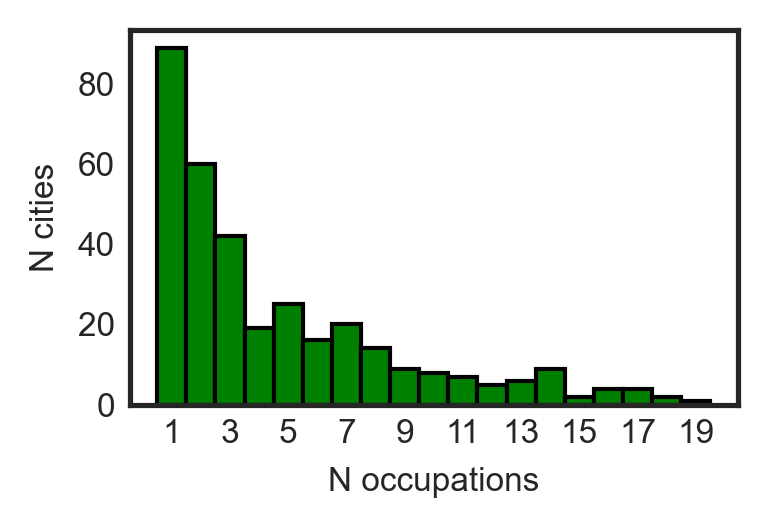

In [58]:
fig, ax = plt.subplots(figsize=(2.6, 1.8), tight_layout=True)
bins = [n+0.5 for n in range(0,20)]
roman_cities_wo["occups_N"].hist(ax=ax, edgecolor="black", color="green", bins=bins)
ax.set_xticks(range(1,20, 2))
ax.grid(False)
ax.set_xlabel("N occupations")
ax.set_ylabel("N cities")

Text(0, 0.5, 'N cities')

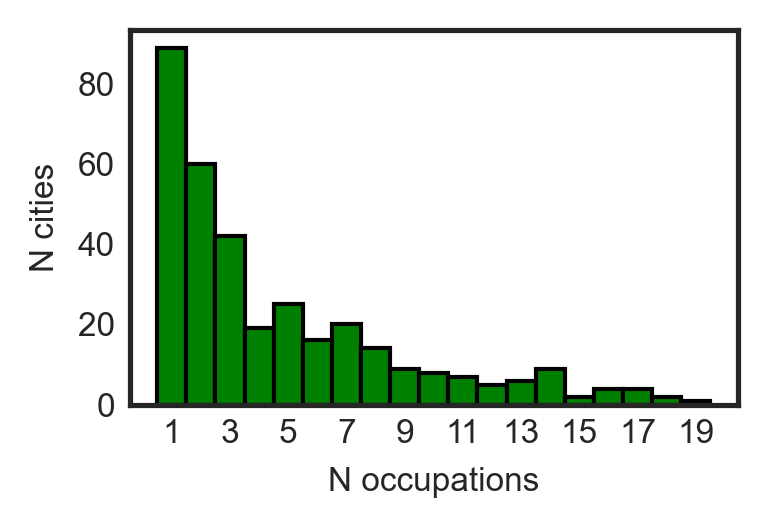

In [59]:
fig, ax = plt.subplots(figsize=(2.6, 1.8), tight_layout=True)
bins = [n+0.5 for n in range(0,20)]
roman_cities_wo["occups_N"].hist(ax=ax, edgecolor="black", color="green", bins=bins)
ax.set_xticks(range(1,20, 2))
ax.grid(False)
ax.set_xlabel("N occupations")
ax.set_ylabel("N cities")

Text(0, 0.5, 'N cities')

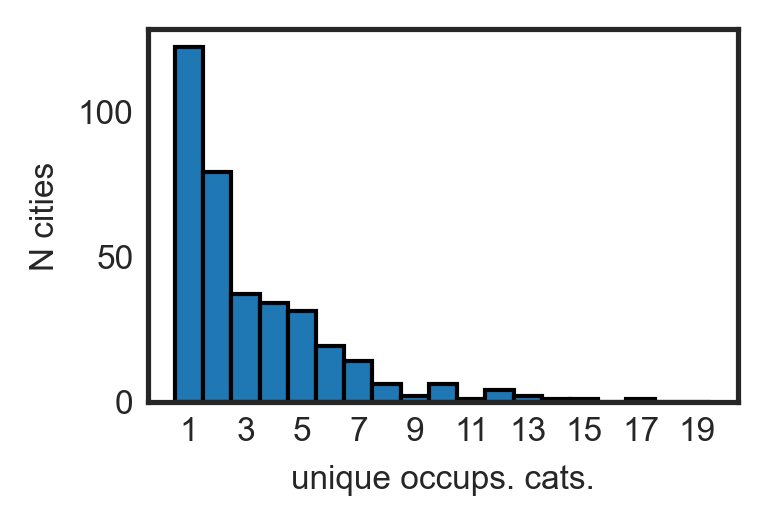

In [60]:
fig, ax = plt.subplots(figsize=(2.6, 1.8), tight_layout=True)
bins = [n+0.5 for n in range(0,20)]
roman_cities_wo["occups_cats_unique_N"].hist(ax=ax, edgecolor="black", bins=bins)
ax.set_xticks(range(1,20, 2))
ax.grid(False)
ax.set_xlabel("unique occups. cats.")
ax.set_ylabel("N cities")

In [61]:
save_figure(fig, "unique_cats_per_cities_hist")

A file with the same name ("unique_cats_per_cities_hist.eps") already exists in this location.
Your <class 'matplotlib.figure.Figure'> object has been succefully written as "https://sciencedata.dk/files/SDAM_root/SDAM_data/social_diversity/socdiv_figures/unique_cats_per_cities_hist.eps"
A file with the same name ("unique_cats_per_cities_hist.png") already exists in this location.
Your <class 'matplotlib.figure.Figure'> object has been succefully written as "https://sciencedata.dk/files/SDAM_root/SDAM_data/social_diversity/socdiv_figures/unique_cats_per_cities_hist.png"


In [62]:
roman_cities_wo["occups_cats_list"]

159                                          [Managerial]
165                            [Managerial, Unclassified]
171     [Managerial, Miscellaneous Services, Miscellan...
173                                       [Metal-Working]
174                              [Miscellaneous Services]
                              ...                        
1297                                       [Unclassified]
1311                                       [Unclassified]
1315                             [Managerial, Managerial]
1317                                         [Managerial]
1321                             [Managerial, Managerial]
Name: occups_cats_list, Length: 360, dtype: object

# Specialization

In [63]:
def get_cat_row_vec(cat_list):
    cat_row_vec = []
    for cat in occups_cats_labels:
        cat_row_vec.append(cat_list.count(cat))
    return np.array(cat_row_vec)


In [64]:
roman_cities_wo["occups_cats_vec"] = roman_cities_wo["occups_cats_list"].apply(get_cat_row_vec)
roman_cities_wo["occups_cats_vec"]

159     [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
165     [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
171     [0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 6, 0, ...
173     [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
174     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...
                              ...                        
1297    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
1311    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
1315    [0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
1317    [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
1321    [0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
Name: occups_cats_vec, Length: 360, dtype: object

In [65]:
def occups_cats_vec_weighted(occups_cat_vec):
    a = np.array(occups_cat_vec, dtype=float)
    a = a / sum(a)
    return a
roman_cities_wo["shares_vec"] = roman_cities_wo["occups_cats_vec"].apply(occups_cats_vec_weighted)
roman_cities_wo["shares_vec"]

159     [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...
165     [0.0, 0.0, 0.0, 0.0, 0.0, 0.5, 0.0, 0.0, 0.0, ...
171     [0.0, 0.0, 0.0, 0.125, 0.0, 0.125, 0.0, 0.0, 0...
173     [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
174     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
                              ...                        
1297    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
1311    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
1315    [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...
1317    [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...
1321    [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...
Name: shares_vec, Length: 360, dtype: object

In [66]:
roman_cities_wo["ZI"] = roman_cities_wo["shares_vec"].apply(max)
roman_cities_wo["ZI"]

159     1.00
165     0.50
171     0.75
173     1.00
174     1.00
        ... 
1297    1.00
1311    1.00
1315    1.00
1317    1.00
1321    1.00
Name: ZI, Length: 360, dtype: float64

In [67]:
roman_cities_wo["largest_cat"] = roman_cities_wo["occups_cats_vec"].apply(max)

In [68]:
roman_cities_wo

,Primary Key,Ancient Toponym,Modern Toponym,Province,Country,Barrington Atlas Rank,Barrington Atlas Reference,Start Date,End Date,Select Bibliography,...,pop_est_log,inscr_N_log,occups_N_log,city_province,occups_cats_list,occups_cats_unique_N,occups_cats_vec,shares_vec,ZI,largest_cat
159,Hanson2016_160,Acholla,Henchir Bou Tria,Africa Proconsularis,Tunisia,4 or 5,33 H2,-200,NaN,BNP; Boatwright 2000; Bomgardner 2000; DGRG; G...,...,6.907755,0.000000,0.000000,Acholla (Africa Proconsularis),[Managerial],1,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",1.00,1
165,Hanson2016_166,Avitta,Henchir Bou Ftis,Africa Proconsularis,Tunisia,3,32 E4,-50,NaN,BNP; Boatwright 2000; Lepelley 1979-1981; Russ...,...,8.905987,1.945910,0.693147,Avitta (Africa Proconsularis),"[Managerial, Unclassified]",2,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.5, 0.0, 0.0, 0.0, ...",0.50,1
171,Hanson2016_172,Carthago,Tunis,Africa Proconsularis,Tunisia,1,32 F3,-49,NaN,Bomgardner 2000; Brunt 1971; Cornell and Mathe...,...,11.533453,6.013715,2.079442,Carthago (Africa Proconsularis),"[Managerial, Miscellaneous Services, Miscellan...",3,"[0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 6, 0, ...","[0.0, 0.0, 0.0, 0.125, 0.0, 0.125, 0.0, 0.0, 0...",0.75,6
173,Hanson2016_174,Cillium,Kasserine,Africa Proconsularis,Tunisia,3,33 C2,69,NaN,Lepelley 1979-1981; PECS; Salmon 1969; Sear 20...,...,8.321908,1.609438,0.000000,Cillium (Africa Proconsularis),[Metal-Working],1,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.00,1
174,Hanson2016_175,Clupea,Kelibia,Africa Proconsularis,Tunisia,4 or 5,32 H3,-310,NaN,BNP; Brunt 1971; Cornell and Mathews 1982; DGR...,...,6.907755,0.693147,0.000000,Clupea (Africa Proconsularis),[Miscellaneous Services],1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.00,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1297,Hanson2016_1298,Catania,Catania,Sicilia,Italy,3,47 G3,-729,NaN,Benario 1981; Brunt 1971; Cornell and Mathews ...,...,10.247432,4.787492,0.000000,Catania (Sicilia),[Unclassified],1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.00,1
1311,Hanson2016_1312,Messana,Messina,Sicilia,Italy,3,47 H2,-730,NaN,Brunt 1971; Cornell and Mathews 1982; Hansen 2...,...,9.351579,1.791759,0.000000,Messana (Sicilia),[Unclassified],1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.00,1
1315,Hanson2016_1316,Panormus,Palermo,Sicilia,Italy,2,47 C2,-700,NaN,Beloch 1886; BNP; Brunt 1971; Cornell and Math...,...,8.521584,3.367296,0.693147,Panormus (Sicilia),"[Managerial, Managerial]",1,"[0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",1.00,2
1317,Hanson2016_1318,Segesta,Segesta,Sicilia,Italy,3,47 B3,-600,NaN,McEvedy 2011; PECS; Sear 2006; Woloch 1983.,...,8.405367,3.332205,0.000000,Segesta (Sicilia),[Managerial],1,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",1.00,1


In [69]:
roman_cities_wo["ZI_cat"] = roman_cities_wo["shares_vec"].apply(lambda x: occups_cats_labels[np.argmax(x)])

In [70]:
roman_cities_wo.sort_values("ZI", ascending=False)[["Ancient Toponym", "inscr_N", "occups_N", "occups_cats_unique_N","occups_cats_vec", "ZI", "ZI_cat"]]

,Ancient Toponym,inscr_N,occups_N,occups_cats_unique_N,occups_cats_vec,ZI,ZI_cat
159,Acholla,1.0,1.0,1,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1.000000,Managerial
840,Sipontum,10.0,1.0,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...",1.000000,Miscellaneous Services
797,Signia,32.0,2.0,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1.000000,Building
807,Trebula Balliensis,30.0,2.0,1,"[0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1.000000,Managerial
813,Vitellia,13.0,2.0,1,"[0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, ...",1.000000,Education
...,...,...,...,...,...,...,...
1271,Mursa,105.0,6.0,6,"[0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, ...",0.166667,Managerial
1045,Ateste,115.0,6.0,6,"[0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, ...",0.166667,Transport
335,Corduba,488.0,30.0,10,"[0, 3, 0, 4, 0, 2, 4, 0, 0, 1, 1, 0, 0, 5, 0, ...",0.166667,Miscellaneous Services
789,Pompeii,3228.0,55.0,12,"[0, 2, 1, 2, 2, 9, 3, 0, 0, 0, 9, 0, 3, 9, 0, ...",0.163636,Managerial


In [71]:
roman_cities_wo["ZIw"] = roman_cities_wo.apply(lambda row: row["ZI"] * row["occups_N_log"], axis=1)
roman_cities_wo.sort_values("ZIw", ascending=False)[["Ancient Toponym", "inscr_N", "occups_N", "occups_list","occups_cats_unique_N", "occups_cats_vec", "ZI", "ZIw", "ZI_cat"]]

,Ancient Toponym,inscr_N,occups_N,occups_list,occups_cats_unique_N,occups_cats_vec,ZI,ZIw,ZI_cat
901,Tibur,235.0,52.0,"[faber, curator, curator, curator, curator, cu...",10,"[0, 0, 1, 3, 0, 31, 1, 5, 0, 0, 1, 0, 1, 1, 0,...",0.596154,2.355549,Managerial
873,Alba Fucentia,81.0,11.0,"[curator, curator, curator, faber tignuarius, ...",2,"[0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0.909091,2.179905,Managerial
808,Tusculum,118.0,18.0,"[curator, curator, curator, curator, curator, ...",5,"[0, 0, 0, 1, 0, 13, 0, 0, 0, 0, 0, 0, 0, 2, 0,...",0.722222,2.087491,Managerial
332,Carmo,8.0,8.0,"[agrimensor, agrimensor, agrimensor, agrimenso...",1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 0, ...",1.000000,2.079442,Miscellaneous Services
1287,Augusta Vindelicum,200.0,10.0,"[negotiator, negotiator, vestiarius, negotiato...",2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...",0.900000,2.072327,Retail
...,...,...,...,...,...,...,...,...,...
690,Caesaraugusta,18.0,1.0,[horrearius],1,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1.000000,0.000000,Managerial
689,Bracara,23.0,1.0,[fullo],1,"[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...",1.000000,0.000000,Clothing
685,Baetulo,34.0,1.0,[curator],1,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1.000000,0.000000,Managerial
649,Mauves,4.0,1.0,[nauta],1,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1.000000,0.000000,Transport


In [72]:
roman_cities_wo["ZIw"] = roman_cities_wo.apply(lambda row: row["ZI"] * row["occups_N_log"], axis=1)
roman_cities_wo.sort_values("ZIw", ascending=False)[["Ancient Toponym", "inscr_N", "occups_N", "occups_list","occups_cats_unique_N", "occups_cats_vec", "ZI", "ZIw", "ZI_cat"]]

,Ancient Toponym,inscr_N,occups_N,occups_list,occups_cats_unique_N,occups_cats_vec,ZI,ZIw,ZI_cat
901,Tibur,235.0,52.0,"[faber, curator, curator, curator, curator, cu...",10,"[0, 0, 1, 3, 0, 31, 1, 5, 0, 0, 1, 0, 1, 1, 0,...",0.596154,2.355549,Managerial
873,Alba Fucentia,81.0,11.0,"[curator, curator, curator, faber tignuarius, ...",2,"[0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0.909091,2.179905,Managerial
808,Tusculum,118.0,18.0,"[curator, curator, curator, curator, curator, ...",5,"[0, 0, 0, 1, 0, 13, 0, 0, 0, 0, 0, 0, 0, 2, 0,...",0.722222,2.087491,Managerial
332,Carmo,8.0,8.0,"[agrimensor, agrimensor, agrimensor, agrimenso...",1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 0, ...",1.000000,2.079442,Miscellaneous Services
1287,Augusta Vindelicum,200.0,10.0,"[negotiator, negotiator, vestiarius, negotiato...",2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...",0.900000,2.072327,Retail
...,...,...,...,...,...,...,...,...,...
690,Caesaraugusta,18.0,1.0,[horrearius],1,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1.000000,0.000000,Managerial
689,Bracara,23.0,1.0,[fullo],1,"[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...",1.000000,0.000000,Clothing
685,Baetulo,34.0,1.0,[curator],1,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1.000000,0.000000,Managerial
649,Mauves,4.0,1.0,[nauta],1,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1.000000,0.000000,Transport


In [73]:
# Total shares
all_occups_N = roman_cities_wo["occups_N"].sum()
index_label_sum_dict = {}
for i, cat in zip(range(len(occups_cats_labels)), occups_cats_labels):
    cat_sum = sum(roman_cities_wo["occups_cats_vec"].apply(lambda vec: vec[i]))
    cat_share = cat_sum / all_occups_N
    index_label_sum_dict[i] = [cat, cat_sum, cat_share]
index_label_sum_dict

{0: ['Glass-Working', 8, 0.0018748535270681978],
 1: ['Plastic Arts', 52, 0.012186547925943286],
 2: ['Transport', 129, 0.03023201312397469],
 3: ['Metal-Working', 389, 0.09116475275369111],
 4: ['Finance', 61, 0.014295758143895007],
 5: ['Managerial', 1006, 0.23576283102882586],
 6: ['Clothing', 277, 0.06491680337473635],
 7: ['Education', 208, 0.048746191703773145],
 8: ['Food-Retail', 44, 0.010311694398875087],
 9: ['Water-Management', 13, 0.0030466369814858216],
 10: ['Performing Arts', 156, 0.03655964377782986],
 11: ['Death-care sector', 0, 0.0],
 12: ['Food-Production', 204, 0.04780876494023904],
 13: ['Miscellaneous Services', 592, 0.13873916100304665],
 14: ['Fuel / Raw material', 1, 0.00023435669088352472],
 15: ['Building', 276, 0.06468244668385283],
 16: ['Retail', 395, 0.09257089289899227],
 17: ['Household Goods', 36, 0.00843684087180689],
 18: ['Unclassified', 420, 0.09842981017108038]}

In [74]:
total_shares = np.array([val[2] for val in index_label_sum_dict.values()])
total_shares

array([1.87485353e-03, 1.21865479e-02, 3.02320131e-02, 9.11647528e-02,
       1.42957581e-02, 2.35762831e-01, 6.49168034e-02, 4.87461917e-02,
       1.03116944e-02, 3.04663698e-03, 3.65596438e-02, 0.00000000e+00,
       4.78087649e-02, 1.38739161e-01, 2.34356691e-04, 6.46824467e-02,
       9.25708929e-02, 8.43684087e-03, 9.84298102e-02])

In [75]:
def get_shares_weighted(vec):
    a = np.array(vec, dtype=float)
    b = total_shares
    shares_weighted =  np.divide(a, b, out=np.zeros_like(a), where=b!=0)
    return shares_weighted

roman_cities_wo["shares_weighted_vec"] = roman_cities_wo["shares_vec"].apply(lambda vec: get_shares_weighted(vec))
roman_cities_wo["shares_weighted_vec"]

159     [0.0, 0.0, 0.0, 0.0, 0.0, 4.24155069582505, 0....
165     [0.0, 0.0, 0.0, 0.0, 0.0, 2.120775347912525, 0...
171     [0.0, 0.0, 0.0, 1.3711439588688947, 0.0, 0.530...
173     [0.0, 0.0, 0.0, 10.969151670951158, 0.0, 0.0, ...
174     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
                              ...                        
1297    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
1311    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
1315    [0.0, 0.0, 0.0, 0.0, 0.0, 4.24155069582505, 0....
1317    [0.0, 0.0, 0.0, 0.0, 0.0, 4.24155069582505, 0....
1321    [0.0, 0.0, 0.0, 0.0, 0.0, 4.24155069582505, 0....
Name: shares_weighted_vec, Length: 360, dtype: object

In [76]:
roman_cities_wo["RZI"] = roman_cities_wo["shares_weighted_vec"].apply(max)
roman_cities_wo["RZI"]

159      4.241551
165      5.079762
171      5.405828
173     10.969152
174      7.207770
          ...    
1297    10.159524
1311    10.159524
1315     4.241551
1317     4.241551
1321     4.241551
Name: RZI, Length: 360, dtype: float64

In [77]:
roman_cities_wo["RZI_cat"] = roman_cities_wo["shares_weighted_vec"].apply(lambda x: index_label_sum_dict[np.argmax(x)][0])
roman_cities_wo["RZI_cat"]

159                 Managerial
165               Unclassified
171     Miscellaneous Services
173              Metal-Working
174     Miscellaneous Services
                 ...          
1297              Unclassified
1311              Unclassified
1315                Managerial
1317                Managerial
1321                Managerial
Name: RZI_cat, Length: 360, dtype: object

In [78]:
roman_cities_wo["RZIw"] = roman_cities_wo.apply(lambda row: row["RZI"] * row["occups_N_log"], axis=1)
roman_cities_wo.sort_values("RZIw", ascending=False)[["Ancient Toponym", "inscr_N", "occups_N", "occups_cats_unique_N", "occups_cats_vec", "ZI", "ZIw", "RZI_cat", "RZI", "RZIw"]]

,Ancient Toponym,inscr_N,occups_N,occups_cats_unique_N,occups_cats_vec,ZI,ZIw,RZI_cat,RZI,RZIw
760,Castrimoenium,135.0,16.0,7,"[0, 0, 0, 0, 1, 7, 1, 0, 0, 0, 3, 0, 0, 0, 1, ...",0.437500,1.213008,Fuel / Raw material,266.687500,739.414755
750,Atella,24.0,5.0,3,"[1, 0, 0, 0, 0, 3, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...",0.600000,0.965663,Glass-Working,106.675000,171.686789
1276,Carnuntum (1),1103.0,19.0,10,"[1, 1, 0, 4, 0, 2, 2, 1, 0, 0, 0, 0, 1, 4, 0, ...",0.210526,0.619882,Glass-Working,28.072368,82.657376
1277,Carnuntum (2),314.0,9.0,7,"[0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, ...",0.222222,0.488272,Water-Management,36.470085,80.132968
663,Andematunum,295.0,11.0,7,"[0, 0, 0, 1, 0, 2, 0, 0, 3, 0, 2, 0, 1, 0, 0, ...",0.272727,0.653971,Food-Retail,26.448347,63.420367
...,...,...,...,...,...,...,...,...,...,...
690,Caesaraugusta,18.0,1.0,1,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1.000000,0.000000,Managerial,4.241551,0.000000
689,Bracara,23.0,1.0,1,"[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...",1.000000,0.000000,Clothing,15.404332,0.000000
685,Baetulo,34.0,1.0,1,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1.000000,0.000000,Managerial,4.241551,0.000000
649,Mauves,4.0,1.0,1,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1.000000,0.000000,Transport,33.077519,0.000000


# Diversity

In [79]:
# again, the starting point are the shares:
roman_cities_wo["shares_vec"]

159     [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...
165     [0.0, 0.0, 0.0, 0.0, 0.0, 0.5, 0.0, 0.0, 0.0, ...
171     [0.0, 0.0, 0.0, 0.125, 0.0, 0.125, 0.0, 0.0, 0...
173     [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
174     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
                              ...                        
1297    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
1311    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
1315    [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...
1317    [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...
1321    [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...
Name: shares_vec, Length: 360, dtype: object

In [80]:
def get_di(shares_vec):
    a = np.array(shares_vec)
    a = a**2
    hh = sum(a) # Hirschman-Herfindahl index
    ihh = 1 / hh # inverse Hirschman-Herfindahl index
    return ihh
roman_cities_wo["DI"] = roman_cities_wo["shares_vec"].apply(get_di)

In [81]:
roman_cities_wo.sort_values("DI", ascending=False)[["Ancient Toponym", "inscr_N", "occups_N", "occups_cats_unique_N", "occups_cats_vec", "DI"]]

,Ancient Toponym,inscr_N,occups_N,occups_cats_unique_N,occups_cats_vec,DI
757,Capua,861.0,46.0,13,"[0, 0, 1, 8, 2, 6, 4, 2, 1, 0, 0, 0, 2, 6, 0, ...",9.446429
335,Corduba,488.0,30.0,10,"[0, 3, 0, 4, 0, 2, 4, 0, 0, 1, 1, 0, 0, 5, 0, ...",8.490566
789,Pompeii,3228.0,55.0,12,"[0, 2, 1, 2, 2, 9, 3, 0, 0, 0, 9, 0, 3, 9, 0, ...",8.473389
672,Mogontiacum,2924.0,48.0,13,"[0, 0, 3, 1, 4, 8, 3, 1, 0, 0, 2, 0, 2, 7, 0, ...",8.287770
787,Ostia,2328.0,245.0,14,"[0, 0, 45, 29, 2, 44, 5, 12, 5, 0, 2, 0, 9, 21...",8.110390
...,...,...,...,...,...,...
786,Nuceria Alfaterna,68.0,1.0,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...",1.000000
796,Setia,11.0,1.0,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...",1.000000
797,Signia,32.0,2.0,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1.000000
807,Trebula Balliensis,30.0,2.0,1,"[0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1.000000


In [82]:
def get_diw(a,b):
    if b==0:
        return 0
    else:
        return a / b
roman_cities_wo["DIw"] = roman_cities_wo.apply(lambda row: get_diw(row["DI"], row['occups_N_log']), axis=1)
roman_cities_wo.sort_values("DIw", ascending=False)[["Ancient Toponym", "inscr_N", "occups_N", "occups_list", "occups_cats_unique_N", "DI", "DIw"]]

,Ancient Toponym,inscr_N,occups_N,occups_list,occups_cats_unique_N,DI,DIw
951,Spoletium,141.0,7.0,"[arcarius, curator, scamillarius, faber, iumen...",7,7.000000,3.597288
1045,Ateste,115.0,6.0,"[navalis, aerarius, curator, medicus, pectinat...",6,6.000000,3.348664
1271,Mursa,105.0,6.0,"[conditor, vexillarius, scriptor, negotiator, ...",6,6.000000,3.348664
986,Pisae,40.0,13.0,"[negotians, vinarius, curator, candidator, sca...",10,8.047619,3.137535
1283,Siscia,112.0,5.0,"[ferrarius, scriba, centonarius, medicus, dend...",5,5.000000,3.106675
...,...,...,...,...,...,...,...
690,Caesaraugusta,18.0,1.0,[horrearius],1,1.000000,0.000000
689,Bracara,23.0,1.0,[fullo],1,1.000000,0.000000
685,Baetulo,34.0,1.0,[curator],1,1.000000,0.000000
649,Mauves,4.0,1.0,[nauta],1,1.000000,0.000000


# Overview tables

### Trier

In [83]:
roman_cities_wo[roman_cities_wo["Modern Toponym"]=="Trier"]

,Primary Key,Ancient Toponym,Modern Toponym,Province,Country,Barrington Atlas Rank,Barrington Atlas Reference,Start Date,End Date,Select Bibliography,...,ZI,largest_cat,ZI_cat,ZIw,shares_weighted_vec,RZI,RZI_cat,RZIw,DI,DIw
586,Hanson2016_587,Colonia Augusta Treverorum,Trier,Gallia Belgica,Germany,2,11 G3,-27,NaN,Bedon 2001; Bedon et al 1988; Benario 1981; Go...,...,0.5,6,Retail,1.242453,"[0.0, 0.0, 0.0, 1.8281919451585262, 5.82923497...",5.829235,Finance,14.485105,3.130435,1.25978


In [84]:
roman_cities_wo.sort_values("ratio_post235", ascending=False).head(20)

,Primary Key,Ancient Toponym,Modern Toponym,Province,Country,Barrington Atlas Rank,Barrington Atlas Reference,Start Date,End Date,Select Bibliography,...,ZI,largest_cat,ZI_cat,ZIw,shares_weighted_vec,RZI,RZI_cat,RZIw,DI,DIw
159,Hanson2016_160,Acholla,Henchir Bou Tria,Africa Proconsularis,Tunisia,4 or 5,33 H2,-200,NaN,BNP; Boatwright 2000; Bomgardner 2000; DGRG; G...,...,1.000000,1,Managerial,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 4.24155069582505, 0....",4.241551,Managerial,0.000000,1.000000,0.000000
174,Hanson2016_175,Clupea,Kelibia,Africa Proconsularis,Tunisia,4 or 5,32 H3,-310,NaN,BNP; Brunt 1971; Cornell and Mathews 1982; DGR...,...,1.000000,1,Miscellaneous Services,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",7.207770,Miscellaneous Services,0.000000,1.000000,0.000000
1166,Hanson2016_1167,Auzia,Aumale,Mauretania Caesariensis,Algeria,3,30 G4,100,NaN,BNP; Lepelley 1979-1981; PECS; Salmon 1969.,...,1.000000,2,Building,0.693147,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",15.460145,Building,10.716156,1.000000,1.442695
586,Hanson2016_587,Colonia Augusta Treverorum,Trier,Gallia Belgica,Germany,2,11 G3,-27,NaN,Bedon 2001; Bedon et al 1988; Benario 1981; Go...,...,0.500000,6,Retail,1.242453,"[0.0, 0.0, 0.0, 1.8281919451585262, 5.82923497...",5.829235,Finance,14.485105,3.130435,1.259780
202,Hanson2016_203,Thibiuca,Henchir Zouitina,Africa Proconsularis,Tunisia,4 or 5,32 E3,100,NaN,Lepelley 1979-1981; Russell 1958; Salmon 1969.,...,1.000000,1,Managerial,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 4.24155069582505, 0....",4.241551,Managerial,0.000000,1.000000,0.000000
649,Hanson2016_650,Mauves,Mauves,Gallia Narbonensis,France,4 or 5,14 D1,-27,NaN,PECS; Sear 2006.,...,1.000000,1,Transport,0.000000,"[0.0, 0.0, 33.07751937984496, 0.0, 0.0, 0.0, 0...",33.077519,Transport,0.000000,1.000000,0.000000
329,Hanson2016_330,Callet,Tajo de Mogarejo,Baetica,Spain,3,26 E4,-49,NaN,MacMullen 2000.,...,1.000000,1,Managerial,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 4.24155069582505, 0....",4.241551,Managerial,0.000000,1.000000,0.000000
190,Hanson2016_191,Oea,Tripoli,Africa Proconsularis,Libya,2,35 F2,-27,NaN,Lepelley 1979-1981; McEvedy 2011; PECS; Salmon...,...,1.000000,1,Managerial,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 4.24155069582505, 0....",4.241551,Managerial,0.000000,1.000000,0.000000
1245,Hanson2016_1246,Hippo Regius,Annaba,Numidia,Algeria,2,31 H3,-100,NaN,BNP; Brunt 1971; DGRG; Lepelley 1979-1981; Mac...,...,1.000000,1,Clothing,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.404332129963...",15.404332,Clothing,0.000000,1.000000,0.000000
173,Hanson2016_174,Cillium,Kasserine,Africa Proconsularis,Tunisia,3,33 C2,69,NaN,Lepelley 1979-1981; PECS; Salmon 1969; Sear 20...,...,1.000000,1,Metal-Working,0.000000,"[0.0, 0.0, 0.0, 10.969151670951158, 0.0, 0.0, ...",10.969152,Metal-Working,0.000000,1.000000,0.000000


In [85]:
lire_sel_cols = ["EDCS-ID", "EDH-ID", "type_of_inscription_auto", "not_before", "not_after", "clean_text_interpretive_word", "occups", "occups_N", "occups_cats_list"]

trier_occups = LIRE[(LIRE["city_ID"]=="587") & (LIRE["occups_N"]>0)][lire_sel_cols]
trier_occups

,EDCS-ID,EDH-ID,type_of_inscription_auto,not_before,not_after,clean_text_interpretive_word,occups,occups_N,occups_cats_list
5284,EDCS-16000492,HD027088,None,151.0,300.0,Deae Minervae Restitutus Gati filius Suessio a...,[aerarius],1,[Metal-Working]
5293,EDCS-11801053,HD049050,epitaph,171.0,230.0,Fortunato negotiatori artis cervesariae ONT MN,[negotiator],1,[Retail]
5316,EDCS-10600409,HD076371,votive inscription,151.0,300.0,In honorem domus divinae Genio arenariorum con...,[arenarius],1,[Performing Arts]
5340,EDCS-10600434,HD076429,votive inscription,1.0,300.0,In honorem domus divinae Moderatius Modestus u...,[negotiator],1,[Retail]
5356,EDCS-10600472,HD078372,epitaph,1.0,300.0,coniugi negotiatori artis R sibi viva fecit,[negotiator],1,[Retail]
5405,EDCS-12000749,HD076322,votive inscription,268.0,300.0,In honorem domus divinae deae Dianae Numini Sa...,[nummularius],1,[Finance]
5407,EDCS-12000751,HD020615,votive inscription,161.0,211.0,Numinibus Augustorum deo Intarabo et Genio col...,[faber dolabrarius],1,[Metal-Working]
5456,EDCS-11201764,HD023872,votive inscription,201.0,300.0,miles classis Germanicae Antoninianae piae fid...,[negotiator cervesarius],1,[Retail]
51592,None,HD078992,identification inscription,151.0,200.0,macellarii cauponem est,"[macellarius, caupo]",2,"[Food-Production, Retail]"
59469,EDCS-73400286,None,None,151.0,200.0,macellarii cauponem est,"[macellarius, caupo]",2,"[Food-Production, Retail]"


In [87]:
#set_with_dataframe(socdiv_results.add_worksheet("trier_feb1", 1,1), trier_occups)
trier_occups.to_csv("../data/occupational_inscriptions_trier.csv", index=False)

In [88]:
all_measures = [["ZIw", "ZI_cat"], ["RZIw", "RZI_cat"], ["DI"], ["DIw"]]
sel_cols = ["Ancient Toponym", "Country", "pop_est", "inscr_N", "occups_N", "largest_cat", "occups_cats_unique_N"]

In [89]:
roman_cities_wo

,Primary Key,Ancient Toponym,Modern Toponym,Province,Country,Barrington Atlas Rank,Barrington Atlas Reference,Start Date,End Date,Select Bibliography,...,ZI,largest_cat,ZI_cat,ZIw,shares_weighted_vec,RZI,RZI_cat,RZIw,DI,DIw
159,Hanson2016_160,Acholla,Henchir Bou Tria,Africa Proconsularis,Tunisia,4 or 5,33 H2,-200,NaN,BNP; Boatwright 2000; Bomgardner 2000; DGRG; G...,...,1.00,1,Managerial,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 4.24155069582505, 0....",4.241551,Managerial,0.000000,1.000000,0.000000
165,Hanson2016_166,Avitta,Henchir Bou Ftis,Africa Proconsularis,Tunisia,3,32 E4,-50,NaN,BNP; Boatwright 2000; Lepelley 1979-1981; Russ...,...,0.50,1,Managerial,0.346574,"[0.0, 0.0, 0.0, 0.0, 0.0, 2.120775347912525, 0...",5.079762,Unclassified,3.521023,2.000000,2.885390
171,Hanson2016_172,Carthago,Tunis,Africa Proconsularis,Tunisia,1,32 F3,-49,NaN,Bomgardner 2000; Brunt 1971; Cornell and Mathe...,...,0.75,6,Miscellaneous Services,1.559581,"[0.0, 0.0, 0.0, 1.3711439588688947, 0.0, 0.530...",5.405828,Miscellaneous Services,11.241103,1.684211,0.809934
173,Hanson2016_174,Cillium,Kasserine,Africa Proconsularis,Tunisia,3,33 C2,69,NaN,Lepelley 1979-1981; PECS; Salmon 1969; Sear 20...,...,1.00,1,Metal-Working,0.000000,"[0.0, 0.0, 0.0, 10.969151670951158, 0.0, 0.0, ...",10.969152,Metal-Working,0.000000,1.000000,0.000000
174,Hanson2016_175,Clupea,Kelibia,Africa Proconsularis,Tunisia,4 or 5,32 H3,-310,NaN,BNP; Brunt 1971; Cornell and Mathews 1982; DGR...,...,1.00,1,Miscellaneous Services,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",7.207770,Miscellaneous Services,0.000000,1.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1297,Hanson2016_1298,Catania,Catania,Sicilia,Italy,3,47 G3,-729,NaN,Benario 1981; Brunt 1971; Cornell and Mathews ...,...,1.00,1,Unclassified,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",10.159524,Unclassified,0.000000,1.000000,0.000000
1311,Hanson2016_1312,Messana,Messina,Sicilia,Italy,3,47 H2,-730,NaN,Brunt 1971; Cornell and Mathews 1982; Hansen 2...,...,1.00,1,Unclassified,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",10.159524,Unclassified,0.000000,1.000000,0.000000
1315,Hanson2016_1316,Panormus,Palermo,Sicilia,Italy,2,47 C2,-700,NaN,Beloch 1886; BNP; Brunt 1971; Cornell and Math...,...,1.00,2,Managerial,0.693147,"[0.0, 0.0, 0.0, 0.0, 0.0, 4.24155069582505, 0....",4.241551,Managerial,2.940019,1.000000,1.442695
1317,Hanson2016_1318,Segesta,Segesta,Sicilia,Italy,3,47 B3,-600,NaN,McEvedy 2011; PECS; Sear 2006; Woloch 1983.,...,1.00,1,Managerial,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 4.24155069582505, 0....",4.241551,Managerial,0.000000,1.000000,0.000000


In [90]:
cols_renaming = {"Ancient Toponym" : "city",
                 "Country" : "country",
                 "pop_est" : "pop. est.",
                 "inscr_N" : "N inscriptions",
                 "occups_N" : "N occupations",
                 "occups_cats_unique_N": "N sectors",
                 "ZI_cat" : "largest sector",
                 "RZI_cat" : "largest sector",
                 "largest_cat" : "N occ. in largest sector"
                 }

In [91]:
def get_sorted_table(df, sel_cols, measures):
    df = df[sel_cols + measures]
    df_sorted = df.sort_values(measures[0], ascending=False)
    for col in ["inscr_N", "pop_est", "occups_N", "occups_cats_unique_N"]:
        df_sorted[col] = df_sorted[col].astype(int)
    for val_col in ["ZIw", "RZIw", "DI", "DIw"]:
        try:
            df_sorted[val_col] = df_sorted[val_col].round(2)
        except:
            pass
    df_sorted = df_sorted.rename(columns=cols_renaming)
    return df_sorted.head(10) # .append(df_sorted.tail(3))

In [92]:
sorted_dfs = {}
for measure_cols in all_measures:
    sorted_dfs["sorted_by_" + measure_cols[0]] = get_sorted_table(roman_cities_wo, sel_cols, measure_cols)

In [93]:
sorted_dfs["sorted_by_ZIw"]

,city,country,pop. est.,N inscriptions,N occupations,N occ. in largest sector,N sectors,ZIw,largest sector
901,Tibur,Italy,6767,235,52,31,10,2.36,Managerial
873,Alba Fucentia,Italy,4471,81,11,10,2,2.18,Managerial
808,Tusculum,Italy,2138,118,18,13,5,2.09,Managerial
332,Carmo,Spain,7172,8,8,8,1,2.08,Miscellaneous Services
1287,Augusta Vindelicum,Germany,10608,200,10,9,2,2.07,Retail
779,Lavinium,Italy,3762,44,13,10,2,1.97,Managerial
991,Roma,Italy,923313,37765,1669,402,17,1.79,Managerial
781,Minturnae,Italy,4471,103,9,7,3,1.71,Managerial
402,Petuaria,United Kingdom,1000,7,5,5,1,1.61,Metal-Working
759,Casinum,Italy,1000,100,16,9,6,1.56,Managerial


In [98]:
# export to gsheets
#set_with_dataframe(socdiv_results.add_worksheet("sorted_by_ZIw_10_jan31", 1,1), sorted_dfs["sorted_by_ZIw"])

In [99]:
# save to csv
sorted_dfs["sorted_by_ZIw"].to_csv("../data/sorted_by_ZIw_10.csv", index=None)

In [100]:
### latex version...

In [101]:
lire_sel_cols = ["EDCS-ID", "EDH-ID", "type_of_inscription_auto", "not_before", "not_after", "clean_text_interpretive_word", "occups", "occups_N", "occups_cats_list"]

### Carmo

In [102]:
roman_cities_wo[roman_cities_wo["Ancient Toponym"]=="Carmo"]

,Primary Key,Ancient Toponym,Modern Toponym,Province,Country,Barrington Atlas Rank,Barrington Atlas Reference,Start Date,End Date,Select Bibliography,...,ZI,largest_cat,ZI_cat,ZIw,shares_weighted_vec,RZI,RZI_cat,RZIw,DI,DIw
332,Hanson2016_333,Carmo,Carmona,Baetica,Spain,3,26 E4,-50,NaN,BNP; Carreras Monfort 1995-1996; Keay 1998; Ne...,...,1.0,8,Miscellaneous Services,2.079442,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",7.20777,Miscellaneous Services,14.988137,1.0,0.480898


In [103]:
carmo_occups = LIRE[(LIRE["city_ID"]=="333") & (LIRE["occups_N"]>0)][lire_sel_cols][lire_sel_cols]
carmo_occups

,EDCS-ID,EDH-ID,type_of_inscription_auto,not_before,not_after,clean_text_interpretive_word,occups,occups_N,occups_cats_list
58538,EDCS-22400457,None,None,69.0,117.0,Cereri Frugiferae sacrum collegium agrimensoru...,"[agrimensor, agrimensor, agrimensor, agrimenso...",8,"[Miscellaneous Services, Miscellaneous Service..."


In [105]:
#set_with_dataframe(socdiv_results.add_worksheet("carmo_feb1", 1,1), carmo_occups)

In [106]:
carmo_occups.to_csv("../data/occupational_inscriptions_carmo.csv", index=False)

In [107]:
roman_cities_wo[roman_cities_wo["Ancient Toponym"]=="Augusta Vindelicum"]

,Primary Key,Ancient Toponym,Modern Toponym,Province,Country,Barrington Atlas Rank,Barrington Atlas Reference,Start Date,End Date,Select Bibliography,...,ZI,largest_cat,ZI_cat,ZIw,shares_weighted_vec,RZI,RZI_cat,RZIw,DI,DIw
1287,Hanson2016_1288,Augusta Vindelicum,Augsburg,Raetia,Germany,2,12 D4,-15,NaN,BNP; Boatwright 2000; McEvedy 2011; PECS; Quin...,...,0.9,9,Retail,2.072327,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",9.722278,Retail,22.386374,1.219512,0.529627


### Augusta vindelicum

In [108]:
augusta_vindelica_occups = LIRE[(LIRE["city_ID"]=="1288") & (LIRE["occups_N"]>0)][lire_sel_cols]
augusta_vindelica_occups

,EDCS-ID,EDH-ID,type_of_inscription_auto,not_before,not_after,clean_text_interpretive_word,occups,occups_N,occups_cats_list
45003,EDCS-27100317,HD058494,building/dedicatory inscription,117.0,300.0,Municipii Aeli Augusti negotiatores vestiariae...,[negotiator],1,[Retail]
45019,EDCS-27100333,HD058555,honorific inscription,171.0,300.0,Iulio Victori negotiatori quondam vestiario ex...,"[negotiator, vestiarius]",2,"[Retail, Retail]"
45027,EDCS-27200188,HD058565,epitaph,171.0,300.0,Perpetuae memoriae et securitati Tiberius Clau...,[negotiator artis purpurariae],1,[Retail]
45033,EDCS-27200194,HD058601,epitaph,171.0,300.0,Memoriae et perpetuae securitati Flabio Acutia...,[negotiator],1,[Retail]
45036,EDCS-27200197,HD058604,epitaph,171.0,300.0,Dis Manibus et perpetuae securitati Victorio V...,"[negotiator, cretaria]",2,"[Retail, Retail]"
45070,EDCS-37600014,HD063792,epitaph,171.0,300.0,lanio Victorino vivis et Iuliae Providentiae c...,[lanius],1,[Food-Production]
45089,EDCS-31001577,HD058010,building/dedicatory inscription,101.0,300.0,Iunianus Pastor negotiatores municipii aedem r...,[negotiator],1,[Retail]
45470,EDCS-73200092,HD072500,epitaph,171.0,250.0,Tiberio Claudio quondam Victori veterano ex nu...,[negotiator artis vestiariae],1,[Retail]


In [110]:
#set_with_dataframe(socdiv_results.add_worksheet("augusta_vindelicum_feb1", 1, 1), augusta_vindelica_occups)

In [111]:
augusta_vindelica_occups.to_csv("../data/occupational_inscriptions_augista_vindelicum.csv", index=False)

In [112]:
# Augusta Vindelicum ZIw score before correction
9/10 * np.log(10)

2.0723265836946414

In [113]:
# Augusta Vindelicum ZIw score after correction
(8/9) * np.log(9)

1.9530885131877507

### Tibur

In [114]:
##
roman_cities_wo[roman_cities_wo["Ancient Toponym"]=="Tibur"]


,Primary Key,Ancient Toponym,Modern Toponym,Province,Country,Barrington Atlas Rank,Barrington Atlas Reference,Start Date,End Date,Select Bibliography,...,ZI,largest_cat,ZI_cat,ZIw,shares_weighted_vec,RZI,RZI_cat,RZIw,DI,DIw
901,Hanson2016_902,Tibur,Tivoli,Italia (IV Samnium),Italy,2,43 D2,-400,NaN,Beloch 1880; Bispham 2007; de Ligt 2012; Golvi...,...,0.596154,31,Managerial,2.355549,"[0.0, 0.0, 0.6361061419200954, 0.6328356733241...",2.528617,Managerial,9.991181,2.6,0.658021


In [115]:
tibur_occups = LIRE[(LIRE["city_ID"]=="902") & (LIRE["occups_N"]>0)][lire_sel_cols]
tibur_occups

,EDCS-ID,EDH-ID,type_of_inscription_auto,not_before,not_after,clean_text_interpretive_word,occups,occups_N,occups_cats_list
29186,EDCS-05801655,HD013460,honorific inscription,38.0,39.0,Caio Maenio Cai filio Camilia Basso aedili III...,[faber],1,[Unclassified]
47700,EDCS-05801900,HD030904,epitaph,218.0,230.0,Caio Caesonio Cai filio Quirina Macro Rufinian...,"[curator, curator, curator, curator, curator, ...",6,"[Managerial, Managerial, Managerial, Manageria..."
47701,EDCS-05801902,HD030907,None,239.0,254.0,Lucius Caesonius Cai filius Quirina Lucillus M...,"[curator, curator, curator, curator]",4,"[Managerial, Managerial, Managerial, Managerial]"
81708,EDCS-05801529,None,None,51.0,150.0,Fortunae praetoriae sacrum Lucius Mucius Nicep...,[curator],1,[Managerial]
81711,EDCS-05801533,None,votive inscription,1.0,100.0,Herculi Victori votum solvit Caius Iulius Cai ...,"[aerarius, curator]",2,"[Metal-Working, Managerial]"
81715,EDCS-05801537,None,None,41.0,70.0,Caius Vibius Cai filius Velina Publilianus scr...,[scriba],1,[Education]
81724,EDCS-05801550,None,votive inscription,1.0,200.0,Publius Flavius Spuri filius Camilia Decimus P...,[curator],1,[Managerial]
81737,EDCS-05801577,None,honorific inscription,201.0,250.0,Publio Aelio Coerano consuli proconsuli provin...,[curator],1,[Managerial]
81743,EDCS-05801583,None,honorific inscription,201.0,238.0,Tito Clodio Marci filio Pupieno Pulchro Maximo...,"[curator, curator, curator, curator]",4,"[Managerial, Managerial, Managerial, Managerial]"
81748,EDCS-05801591,None,honorific inscription,172.0,172.0,Publio Mummio Publi filio Galeria Sisennae Rut...,"[aerarius, curator]",2,"[Metal-Working, Managerial]"


In [116]:
#set_with_dataframe(socdiv_results.add_worksheet("tibur_feb1", 1,1), tibur_occups)

In [115]:
tibur_occups.to_csv("../data/occupational_inscriptions_tibur.csv", index=False)

### RZIw

In [117]:
sorted_dfs["sorted_by_RZIw"]

,city,country,pop. est.,N inscriptions,N occupations,N occ. in largest sector,N sectors,RZIw,largest sector
760,Castrimoenium,Italy,1000,135,16,7,7,739.41,Fuel / Raw material
750,Atella,Italy,7790,24,5,3,3,171.69,Glass-Working
1276,Carnuntum (1),Austria,7790,1103,19,4,10,82.66,Glass-Working
1277,Carnuntum (2),Austria,9938,314,9,2,7,80.13,Water-Management
663,Andematunum,France,5782,295,11,3,7,63.42,Food-Retail
666,Argentoratum,France,8848,178,5,2,3,52.83,Plastic Arts
897,Sulmo,Italy,1559,126,7,2,5,45.62,Plastic Arts
1010,Caesena,Italy,2444,16,3,2,2,43.41,Household Goods
335,Corduba,Spain,19404,488,30,5,10,37.21,Water-Management
1236,Virunum,Austria,7172,340,8,2,5,36.36,Finance


In [118]:
sorted_dfs["sorted_by_RZIw"].to_csv("../data/sorted_by_RZIw_10.csv", index=None)

### DI

In [119]:
sorted_dfs["sorted_by_DI"]

,city,country,pop. est.,N inscriptions,N occupations,N occ. in largest sector,N sectors,DI
757,Capua,Italy,44416,861,46,8,13,9.45
335,Corduba,Spain,19404,488,30,5,10,8.49
789,Pompeii,Italy,9938,3228,55,9,12,8.47
672,Mogontiacum,Germany,19930,2924,48,10,13,8.29
787,Ostia,Italy,35016,2328,245,45,14,8.11
986,Pisae,Italy,3937,40,13,3,10,8.05
793,Puteoli,Italy,25091,1343,77,15,15,8.04
991,Roma,Italy,923313,37765,1669,402,17,7.73
1268,Brigetio,Hungary,7999,378,14,3,9,7.54
1276,Carnuntum (1),Austria,7790,1103,19,4,10,7.37


In [120]:
### latex version...

In [121]:
# export to gsheets
#set_with_dataframe(socdiv_results.add_worksheet("sorted_by_DI_10_jan31", 1,1), sorted_dfs["sorted_by_DI"])

In [102]:
sorted_dfs["sorted_by_DI"].to_csv("../data/sorted_by_DI_10.csv", index=None)

### Capua

In [122]:
roman_cities_wo[roman_cities_wo["Ancient Toponym"]=="Capua"]

,Primary Key,Ancient Toponym,Modern Toponym,Province,Country,Barrington Atlas Rank,Barrington Atlas Reference,Start Date,End Date,Select Bibliography,...,ZI,largest_cat,ZI_cat,ZIw,shares_weighted_vec,RZI,RZI_cat,RZIw,DI,DIw
757,Hanson2016_758,Capua,S. Maria di Capua Vetere,Italia (I Latium and Campania),Italy,2,44 F3,-550,NaN,Beloch 1880; Beloch 1886; Benario 1981; Bispha...,...,0.173913,8,Metal-Working,0.665851,"[0.0, 0.0, 0.7190765082574991, 1.9076785514697...",3.04134,Finance,11.6442,9.446429,2.467306


In [123]:
capua_occups = LIRE[(LIRE["city_ID"]=="758") & (LIRE["occups_N"]>0)][lire_sel_cols]
capua_occups

,EDCS-ID,EDH-ID,type_of_inscription_auto,not_before,not_after,clean_text_interpretive_word,occups,occups_N,occups_cats_list
28575,EDCS-41700240,HD004129,epitaph,1.0,100.0,Lucius Campanius Luci filius Flaccus tribunus ...,[faber],1,[Unclassified]
28580,EDCS-18000373,HD004123,None,-100.0,-31.0,Lucius Avius Marci libertus Eunicus aerarius m...,[aerarius],1,[Metal-Working]
28593,EDCS-08600107,HD001190,building/dedicatory inscription,-70.0,-31.0,Publius Confuleius Publi et Marci libertus Sab...,"[architectus, sagarius]",2,"[Building, Retail]"
71056,EDCS-17800417,None,votive inscription,-12.0,-12.0,Publio Sulpicio Quirinio Caio Valgio consulibu...,[navigator],1,[Transport]
71062,EDCS-17800434,None,votive inscription,151.0,200.0,Genius theatri Lucceius Peculiaris redemptor p...,[redemptor],1,[Food-Production]
71070,EDCS-17800443,None,None,102.0,116.0,In honorem divi Vespasiani et divi Titi divi V...,[faber],1,[Unclassified]
71079,EDCS-17900555,None,None,331.0,395.0,Argentii Brittio Praetextato viro clarissimo c...,[curator],1,[Managerial]
71088,EDCS-17900566,None,None,271.0,400.0,Carradii Iulio Aurelio Auxonti Leonidae viro c...,[curator],1,[Managerial]
71094,EDCS-17900574,None,epitaph,101.0,200.0,Dis Manibus sacrum Marco Veserio Marci filio P...,[faber],1,[Unclassified]
71102,EDCS-17900586,None,epitaph,1.0,50.0,Caius Papius Cai libertus Salvius Caius Papius...,[argentarius],1,[Metal-Working]


In [124]:
#set_with_dataframe(socdiv_results.add_worksheet("capua_feb1", 1,1), capua_occups)

In [125]:
capua_occups.to_csv("../data/occupational_inscriptions_capua.csv", index=False)

### Pisae

In [126]:
roman_cities_wo[roman_cities_wo["Ancient Toponym"]=="Pisae"]

,Primary Key,Ancient Toponym,Modern Toponym,Province,Country,Barrington Atlas Rank,Barrington Atlas Reference,Start Date,End Date,Select Bibliography,...,ZI,largest_cat,ZI_cat,ZIw,shares_weighted_vec,RZI,RZI_cat,RZIw,DI,DIw
986,Hanson2016_987,Pisae,Pisa,Italia (VII Etruria),Italy,2,41 C2,-500,NaN,Beloch 1880; Bispham 2007; BNP; Cornell and Ma...,...,0.230769,3,Transport,0.591911,"[0.0, 0.0, 7.633273703041145, 0.84378089776547...",7.633274,Transport,19.57896,8.047619,3.137535


In [127]:
pisae_occups = LIRE[(LIRE["city_ID"]=="987") & (LIRE["occups_N"]>0)][lire_sel_cols]
pisae_occups

,EDCS-ID,EDH-ID,type_of_inscription_auto,not_before,not_after,clean_text_interpretive_word,occups,occups_N,occups_cats_list
19987,EDCS-08600246,HD001251,epitaph,151.0,250.0,m quinquennali curatori negotiantium vinarioru...,"[negotians, vinarius, curator]",3,"[Retail, Food-Retail, Managerial]"
63403,EDCS-20402891,None,None,4.0,14.0,scribendo adfuerunt Quintus Sertorius Quinti f...,"[candidator, scaenicus, scriba]",3,"[Clothing, Performing Arts, Education]"
63406,EDCS-20402907,None,epitaph,101.0,200.0,Dis Manibus Venuleia Pelagia hic adquiescit fi...,"[faber tignarius, faber navalis, navalis, faber]",4,"[Building, Transport, Transport, Unclassified]"
63411,EDCS-20402916,None,epitaph,101.0,200.0,Dis Manibus Mettia Ianuaria hic adquiescit con...,[curator],1,[Managerial]
63414,EDCS-20402920,None,epitaph,101.0,200.0,Dis Manibus Anniae Iucundae Marci Anni Proculi...,[faber navalis],1,[Transport]
63424,EDCS-20402971,None,epitaph,101.0,200.0,Dis Manibus Caius Veianius Helittas fecit sibi...,[aerarius],1,[Metal-Working]


In [129]:
#set_with_dataframe(socdiv_results.add_worksheet("pisae_feb1", 1,1), pisae_occups)
pisae_occups.to_csv("../data/occupational_inscriptions_pisae.csv", index=False)

### DIw

In [130]:
sorted_dfs["sorted_by_DIw"]

,city,country,pop. est.,N inscriptions,N occupations,N occ. in largest sector,N sectors,DIw
951,Spoletium,Italy,2760,141,7,1,7,3.60
1045,Ateste,Italy,7790,115,6,1,6,3.35
1271,Mursa,Croatia,7376,105,6,1,6,3.35
986,Pisae,Italy,3937,40,13,3,10,3.14
1283,Siscia,Croatia,3086,112,5,1,5,3.11
325,Astigi,Spain,13870,170,5,1,5,3.11
883,Corfinium,Italy,1030,289,10,2,8,3.10
984,Nepet,Italy,1157,25,2,1,2,2.89
397,Lindum,United Kingdom,5976,48,2,1,2,2.89
399,Luguvalium,United Kingdom,3590,144,2,1,2,2.89


In [131]:
sorted_dfs["sorted_by_DIw"].to_csv("../data/sorted_by_DIw_10.csv", index=False)

In [132]:
def get_dzi(row):
    try:
        dzi = row["DI"] / row["ZIw"]
    except:
        dzi = 0
    return dzi


roman_cities_wo["DI/ZIw"] = roman_cities_wo.apply(lambda row: get_dzi(row), axis=1)

In [133]:
roman_cities_wo.head(5)

,Primary Key,Ancient Toponym,Modern Toponym,Province,Country,Barrington Atlas Rank,Barrington Atlas Reference,Start Date,End Date,Select Bibliography,...,largest_cat,ZI_cat,ZIw,shares_weighted_vec,RZI,RZI_cat,RZIw,DI,DIw,DI/ZIw
159,Hanson2016_160,Acholla,Henchir Bou Tria,Africa Proconsularis,Tunisia,4 or 5,33 H2,-200,NaN,BNP; Boatwright 2000; Bomgardner 2000; DGRG; G...,...,1,Managerial,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 4.24155069582505, 0....",4.241551,Managerial,0.000000,1.000000,0.000000,0.000000
165,Hanson2016_166,Avitta,Henchir Bou Ftis,Africa Proconsularis,Tunisia,3,32 E4,-50,NaN,BNP; Boatwright 2000; Lepelley 1979-1981; Russ...,...,1,Managerial,0.346574,"[0.0, 0.0, 0.0, 0.0, 0.0, 2.120775347912525, 0...",5.079762,Unclassified,3.521023,2.000000,2.885390,5.770780
171,Hanson2016_172,Carthago,Tunis,Africa Proconsularis,Tunisia,1,32 F3,-49,NaN,Bomgardner 2000; Brunt 1971; Cornell and Mathe...,...,6,Miscellaneous Services,1.559581,"[0.0, 0.0, 0.0, 1.3711439588688947, 0.0, 0.530...",5.405828,Miscellaneous Services,11.241103,1.684211,0.809934,1.079912
173,Hanson2016_174,Cillium,Kasserine,Africa Proconsularis,Tunisia,3,33 C2,69,NaN,Lepelley 1979-1981; PECS; Salmon 1969; Sear 20...,...,1,Metal-Working,0.000000,"[0.0, 0.0, 0.0, 10.969151670951158, 0.0, 0.0, ...",10.969152,Metal-Working,0.000000,1.000000,0.000000,0.000000
174,Hanson2016_175,Clupea,Kelibia,Africa Proconsularis,Tunisia,4 or 5,32 H3,-310,NaN,BNP; Brunt 1971; Cornell and Mathews 1982; DGR...,...,1,Miscellaneous Services,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",7.207770,Miscellaneous Services,0.000000,1.000000,0.000000,0.000000


# Hanson 2017

In [134]:
# Hanson et al. 2017 on associations
hanson_assoc = pd.read_excel("../data/hanson2017_supplementary.xlsx")
hanson_assoc.head(10)

,Primary key,Name,Province,Population,associations,inscriptions,D(N),West / East
0,992,Roma,Italia (VII Etruria),923406,155,119532,1197.402620,West
1,110,Alexandria (Aegyptus),Aegyptus,410535,7,203,14156.379310,East
2,172,Carthago,Africa Proconsularis,102170,7,8445,84.687981,West
3,1320,Syracusae,Silicia,83834,1,578,145.041522,West
4,276,Ephesus,Asia,71587,4,373,767.689008,East
5,1325,Apamea (Syria) (1),Syria,64408,1,53,1215.245283,East
6,14,Athenae,Achaea,58114,5,275,1056.618182,East
7,1022,Ravenna,Italia (VIII Aemilia),49652,5,736,337.309783,West
8,13,Argos,Achaea,49453,1,24,2060.541667,East
9,315,Smyrna,Asia,47672,8,20,19068.800000,East


In [135]:
hanson_assoc.drop(["Province"], axis=1, inplace=True)

hanson_assoc["Primary key"] = hanson_assoc["Primary key"].apply(str)

roman_cities_wo["Primary key"] = roman_cities_wo["Primary Key"].apply(lambda x: x.rpartition("_")[2])

In [136]:
roman_cities_wo

,Primary Key,Ancient Toponym,Modern Toponym,Province,Country,Barrington Atlas Rank,Barrington Atlas Reference,Start Date,End Date,Select Bibliography,...,ZI_cat,ZIw,shares_weighted_vec,RZI,RZI_cat,RZIw,DI,DIw,DI/ZIw,Primary key
159,Hanson2016_160,Acholla,Henchir Bou Tria,Africa Proconsularis,Tunisia,4 or 5,33 H2,-200,NaN,BNP; Boatwright 2000; Bomgardner 2000; DGRG; G...,...,Managerial,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 4.24155069582505, 0....",4.241551,Managerial,0.000000,1.000000,0.000000,0.000000,160
165,Hanson2016_166,Avitta,Henchir Bou Ftis,Africa Proconsularis,Tunisia,3,32 E4,-50,NaN,BNP; Boatwright 2000; Lepelley 1979-1981; Russ...,...,Managerial,0.346574,"[0.0, 0.0, 0.0, 0.0, 0.0, 2.120775347912525, 0...",5.079762,Unclassified,3.521023,2.000000,2.885390,5.770780,166
171,Hanson2016_172,Carthago,Tunis,Africa Proconsularis,Tunisia,1,32 F3,-49,NaN,Bomgardner 2000; Brunt 1971; Cornell and Mathe...,...,Miscellaneous Services,1.559581,"[0.0, 0.0, 0.0, 1.3711439588688947, 0.0, 0.530...",5.405828,Miscellaneous Services,11.241103,1.684211,0.809934,1.079912,172
173,Hanson2016_174,Cillium,Kasserine,Africa Proconsularis,Tunisia,3,33 C2,69,NaN,Lepelley 1979-1981; PECS; Salmon 1969; Sear 20...,...,Metal-Working,0.000000,"[0.0, 0.0, 0.0, 10.969151670951158, 0.0, 0.0, ...",10.969152,Metal-Working,0.000000,1.000000,0.000000,0.000000,174
174,Hanson2016_175,Clupea,Kelibia,Africa Proconsularis,Tunisia,4 or 5,32 H3,-310,NaN,BNP; Brunt 1971; Cornell and Mathews 1982; DGR...,...,Miscellaneous Services,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",7.207770,Miscellaneous Services,0.000000,1.000000,0.000000,0.000000,175
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1297,Hanson2016_1298,Catania,Catania,Sicilia,Italy,3,47 G3,-729,NaN,Benario 1981; Brunt 1971; Cornell and Mathews ...,...,Unclassified,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",10.159524,Unclassified,0.000000,1.000000,0.000000,0.000000,1298
1311,Hanson2016_1312,Messana,Messina,Sicilia,Italy,3,47 H2,-730,NaN,Brunt 1971; Cornell and Mathews 1982; Hansen 2...,...,Unclassified,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",10.159524,Unclassified,0.000000,1.000000,0.000000,0.000000,1312
1315,Hanson2016_1316,Panormus,Palermo,Sicilia,Italy,2,47 C2,-700,NaN,Beloch 1886; BNP; Brunt 1971; Cornell and Math...,...,Managerial,0.693147,"[0.0, 0.0, 0.0, 0.0, 0.0, 4.24155069582505, 0....",4.241551,Managerial,2.940019,1.000000,1.442695,1.442695,1316
1317,Hanson2016_1318,Segesta,Segesta,Sicilia,Italy,3,47 B3,-600,NaN,McEvedy 2011; PECS; Sear 2006; Woloch 1983.,...,Managerial,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 4.24155069582505, 0....",4.241551,Managerial,0.000000,1.000000,0.000000,0.000000,1318


In [137]:
roman_cities_wo = roman_cities_wo.merge(hanson_assoc, on="Primary key", how="left")
roman_cities_wo

,Primary Key,Ancient Toponym,Modern Toponym,Province,Country,Barrington Atlas Rank,Barrington Atlas Reference,Start Date,End Date,Select Bibliography,...,DI,DIw,DI/ZIw,Primary key,Name,Population,associations,inscriptions,D(N),West / East
0,Hanson2016_160,Acholla,Henchir Bou Tria,Africa Proconsularis,Tunisia,4 or 5,33 H2,-200,NaN,BNP; Boatwright 2000; Bomgardner 2000; DGRG; G...,...,1.000000,0.000000,0.000000,160,NaN,NaN,NaN,NaN,NaN,NaN
1,Hanson2016_166,Avitta,Henchir Bou Ftis,Africa Proconsularis,Tunisia,3,32 E4,-50,NaN,BNP; Boatwright 2000; Lepelley 1979-1981; Russ...,...,2.000000,2.885390,5.770780,166,NaN,NaN,NaN,NaN,NaN,NaN
2,Hanson2016_172,Carthago,Tunis,Africa Proconsularis,Tunisia,1,32 F3,-49,NaN,Bomgardner 2000; Brunt 1971; Cornell and Mathe...,...,1.684211,0.809934,1.079912,172,Carthago,102170.0,7.0,8445.0,84.687981,West
3,Hanson2016_174,Cillium,Kasserine,Africa Proconsularis,Tunisia,3,33 C2,69,NaN,Lepelley 1979-1981; PECS; Salmon 1969; Sear 20...,...,1.000000,0.000000,0.000000,174,NaN,NaN,NaN,NaN,NaN,NaN
4,Hanson2016_175,Clupea,Kelibia,Africa Proconsularis,Tunisia,4 or 5,32 H3,-310,NaN,BNP; Brunt 1971; Cornell and Mathews 1982; DGR...,...,1.000000,0.000000,0.000000,175,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
355,Hanson2016_1298,Catania,Catania,Sicilia,Italy,3,47 G3,-729,NaN,Benario 1981; Brunt 1971; Cornell and Mathews ...,...,1.000000,0.000000,0.000000,1298,Catania,28211.0,2.0,658.0,85.747720,West
356,Hanson2016_1312,Messana,Messina,Sicilia,Italy,3,47 H2,-730,NaN,Brunt 1971; Cornell and Mathews 1982; Hansen 2...,...,1.000000,0.000000,0.000000,1312,Messana,11531.0,1.0,156.0,73.916667,West
357,Hanson2016_1316,Panormus,Palermo,Sicilia,Italy,2,47 C2,-700,NaN,Beloch 1886; BNP; Brunt 1971; Cornell and Math...,...,1.000000,1.442695,1.442695,1316,Panormus,5067.0,1.0,213.0,23.788732,West
358,Hanson2016_1318,Segesta,Segesta,Sicilia,Italy,3,47 B3,-600,NaN,McEvedy 2011; PECS; Sear 2006; Woloch 1983.,...,1.000000,0.000000,0.000000,1318,NaN,NaN,NaN,NaN,NaN,NaN


# Export whole dataset

In [192]:
roman_cities_wo.to_parquet("../data/roman_cities_wo.parquet")
roman_cities_wo.to_csv("../data/roman_cities_wo.csv")
#set_with_dataframe(socdiv_results.add_worksheet("roman_cities_wo_full_feb2", 1,1), roman_cities_wo)

# Correlation matrix

In [138]:
selected_cols = ["ID", "Ancient Toponym", "pop_est", "Structure", "inscr_N", "occups_N", "occups_list", "occups_unique_N", "occups_cats_unique_N", "largest_cat", "ZIw", "ZI_cat", "RZIw", "RZI_cat", "DI", "DIw", "DI/ZIw"]
#set_with_dataframe(socdiv_results.add_worksheet("roman_cities_wo_sel_20211227", 1,1), roman_cities_wo[selected_cols])

In [139]:
roman_cities_wo_quant = roman_cities_wo[
    (roman_cities_wo["Ancient Toponym"]!="Roma")
    & (roman_cities_wo["occups_N"]>=2)][[
   'Area', 'num_of_structures','pop_est', 'pop_est_log', 'inscr_N',  'inscr_N_log', 'occups_N', 'occups_N_log', 'ZIw', "RZIw",'DI',"DIw", "DI/ZIw", "ratio_post235"]]

In [140]:
len(roman_cities_wo_quant)

270

In [141]:
corr_matrix = roman_cities_wo_quant.corr()
corr_matrix = corr_matrix.round(2)
corr_matrix

,Area,num_of_structures,pop_est,pop_est_log,inscr_N,inscr_N_log,occups_N,occups_N_log,ZIw,RZIw,DI,DIw,DI/ZIw,ratio_post235
Area,1.00,0.54,0.98,0.84,0.25,0.34,0.26,0.27,0.12,0.05,0.17,-0.11,0.03,0.11
num_of_structures,0.54,1.00,0.51,0.48,0.37,0.39,0.38,0.35,0.17,-0.05,0.23,-0.13,0.06,0.13
pop_est,0.98,0.51,1.00,0.71,0.21,0.28,0.22,0.24,0.13,-0.02,0.13,-0.12,0.01,0.10
pop_est_log,0.84,0.48,0.71,1.00,0.32,0.43,0.29,0.33,0.09,-0.04,0.28,-0.04,0.13,0.12
inscr_N,0.25,0.37,0.21,0.32,1.00,0.68,0.70,0.59,0.11,0.04,0.52,-0.04,0.22,0.04
inscr_N_log,0.34,0.39,0.28,0.43,0.68,1.00,0.49,0.65,0.15,0.07,0.60,-0.02,0.30,0.02
occups_N,0.26,0.38,0.22,0.29,0.70,0.49,1.00,0.71,0.23,0.06,0.52,-0.13,0.16,0.03
occups_N_log,0.27,0.35,0.24,0.33,0.59,0.65,0.71,1.00,0.48,0.14,0.75,-0.27,0.24,0.00
ZIw,0.12,0.17,0.13,0.09,0.11,0.15,0.23,0.48,1.00,0.08,-0.16,-0.87,-0.57,0.06
RZIw,0.05,-0.05,-0.02,-0.04,0.04,0.07,0.06,0.14,0.08,1.00,0.10,-0.04,0.02,-0.07


<AxesSubplot:>

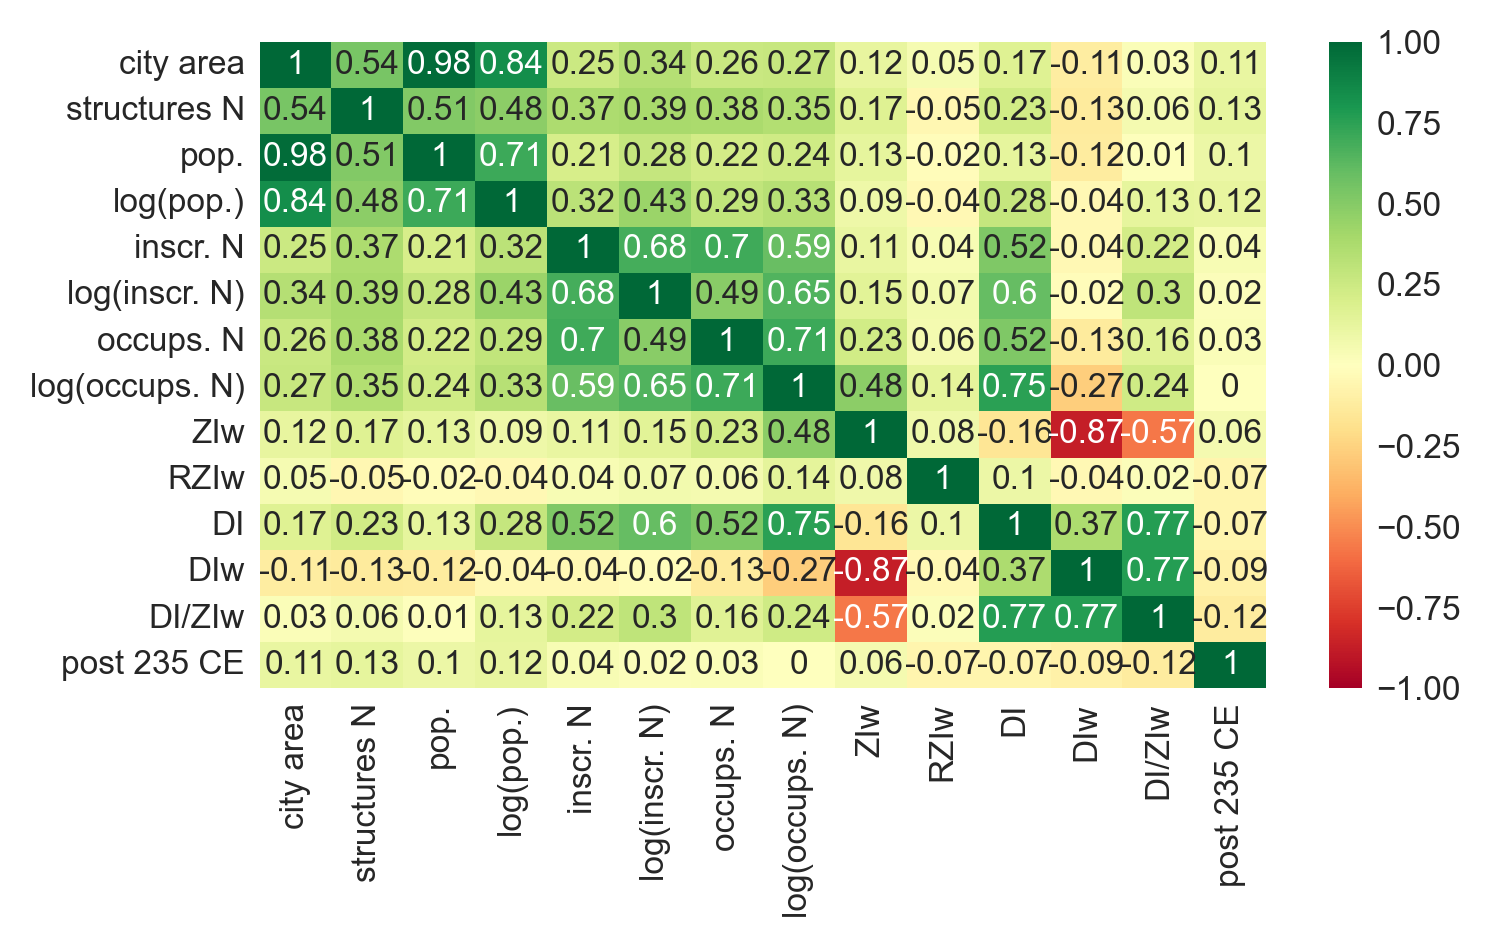

In [142]:
col_labels = ["city area", "structures N", "pop.", "log(pop.)", "inscr. N", "log(inscr. N)", "occups. N", "log(occups. N)", "ZIw", "RZIw", "DI", "DIw", "DI/ZIw", "post 235 CE"]
fig,ax=plt.subplots(figsize=(5.2,3.2), tight_layout=True)
sns.heatmap(corr_matrix, xticklabels=col_labels, yticklabels=col_labels, ax=ax,  cmap="RdYlGn", vmin=-1, vmax=1, annot=True)

In [143]:
save_figure(fig, "DI_ZI_corr_matrix")

A file with the same name ("DI_ZI_corr_matrix.eps") already exists in this location.
Your <class 'matplotlib.figure.Figure'> object has been succefully written as "https://sciencedata.dk/files/SDAM_root/SDAM_data/social_diversity/socdiv_figures/DI_ZI_corr_matrix.eps"
A file with the same name ("DI_ZI_corr_matrix.png") already exists in this location.
Your <class 'matplotlib.figure.Figure'> object has been succefully written as "https://sciencedata.dk/files/SDAM_root/SDAM_data/social_diversity/socdiv_figures/DI_ZI_corr_matrix.png"


In [144]:
def get_pvalue_matrix(df):
    df = df.dropna()._get_numeric_data()
    listlist_pvalues = []
    for r in df.columns:
        row_pvalues = []
        for c in df.columns:
            try:
                row_pvalues.append(round(pearsonr(df[r], df[c])[1], 5))
            except:
                row_pvalues.append(None)
        listlist_pvalues.append(row_pvalues)
    return pd.DataFrame(listlist_pvalues, columns=df.columns, index=df.columns)

In [145]:
pvalue_matrix = get_pvalue_matrix(roman_cities_wo_quant)
pvalue_matrix

,Area,num_of_structures,pop_est,pop_est_log,inscr_N,inscr_N_log,occups_N,occups_N_log,ZIw,RZIw,DI,DIw,DI/ZIw,ratio_post235
Area,0.00000,0.00000,0.00000,0.00000,0.00005,0.00000,0.00005,0.00001,0.05093,0.44741,0.00738,0.08459,0.61406,0.08920
num_of_structures,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.01692,0.56748,0.00015,0.08316,0.27820,0.07979
pop_est,0.00000,0.00000,0.00000,0.00000,0.00137,0.00001,0.00084,0.00027,0.04567,0.72954,0.06910,0.04800,0.96104,0.10324
pop_est_log,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00001,0.00000,0.14480,0.07808,0.00003,0.50346,0.06558,0.06180
inscr_N,0.00005,0.00000,0.00137,0.00000,0.00000,0.00000,0.00000,0.00000,0.10403,0.03230,0.00000,0.55464,0.00045,0.58233
inscr_N_log,0.00000,0.00000,0.00001,0.00000,0.00000,0.00000,0.00000,0.00000,0.02370,0.01065,0.00000,0.61341,0.00000,0.70584
occups_N,0.00005,0.00000,0.00084,0.00001,0.00000,0.00000,0.00000,0.00000,0.00029,0.07047,0.00000,0.04258,0.01472,0.59590
occups_N_log,0.00001,0.00000,0.00027,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00102,0.00000,0.00003,0.00017,0.82559
ZIw,0.05093,0.01692,0.04567,0.14480,0.10403,0.02370,0.00029,0.00000,0.00000,0.82817,0.00649,0.00000,0.00000,0.31566
RZIw,0.44741,0.56748,0.72954,0.07808,0.03230,0.01065,0.07047,0.00102,0.82817,0.00000,0.00006,0.80555,0.00638,0.09414


<AxesSubplot:>

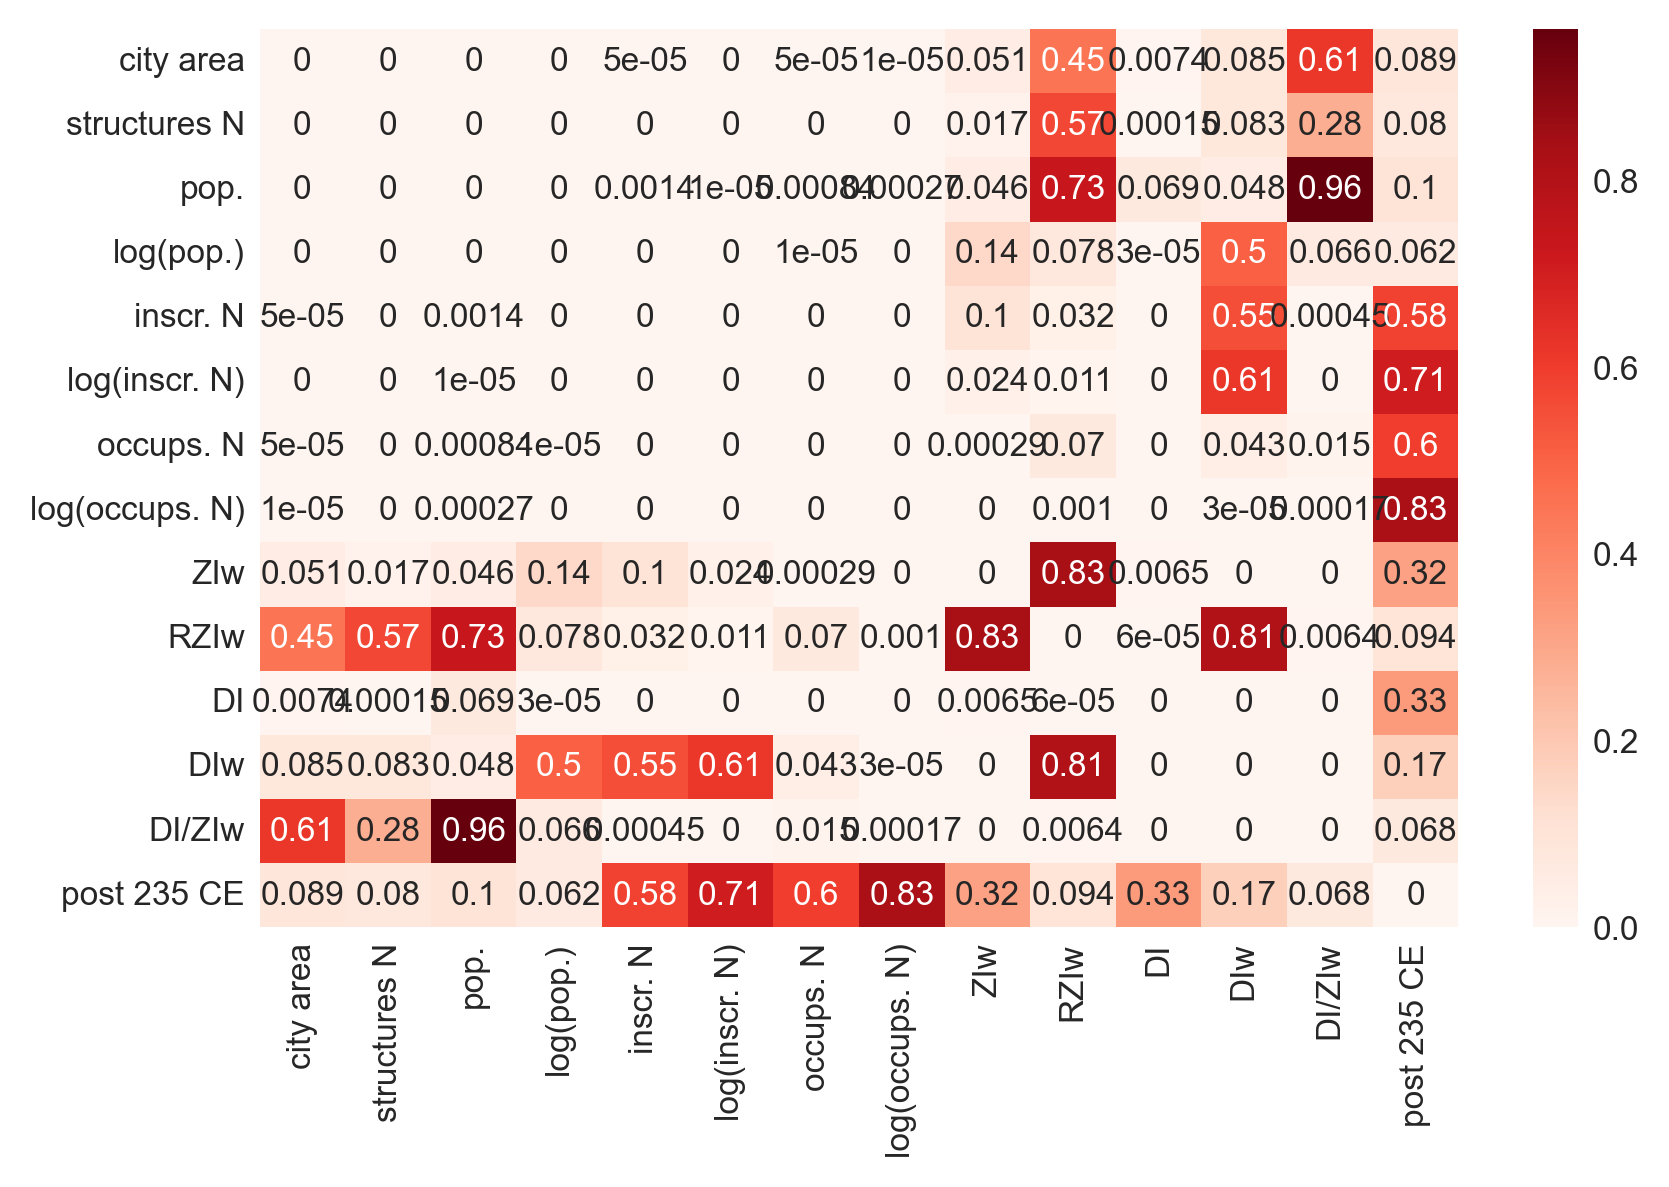

In [146]:
fig,ax=plt.subplots(tight_layout=True)
sns.heatmap(pvalue_matrix, xticklabels=col_labels, yticklabels=col_labels, ax=ax, cmap="Reds", annot=True)

selected_cols = ["ID", "Ancient Toponym", "pop_est", "Structure", "inscr_N", "occups_N", "occups_list", "occups_unique_N", "occups_cats_unique_N", "largest_cat", "ZIw", "ZI_cat", "RZIw", "RZI_cat", "DI", "DIw", "DI/ZIw"]
#set_with_dataframe(socdiv_results.add_worksheet("roman_cities_wo_sel_20211227", 1,1), roman_cities_wo[selected_cols])

# Comparison with Hanson et al. 2017 results

In [147]:
roman_cities_wo[roman_cities_wo["D(N)"].notnull()]

,Primary Key,Ancient Toponym,Modern Toponym,Province,Country,Barrington Atlas Rank,Barrington Atlas Reference,Start Date,End Date,Select Bibliography,...,DI,DIw,DI/ZIw,Primary key,Name,Population,associations,inscriptions,D(N),West / East
2,Hanson2016_172,Carthago,Tunis,Africa Proconsularis,Tunisia,1,32 F3,-49,NaN,Bomgardner 2000; Brunt 1971; Cornell and Mathe...,...,1.684211,0.809934,1.079912,172,Carthago,102170.0,7.0,8445.0,84.687981,West
14,Hanson2016_210,Thugga,Dougga,Africa Proconsularis,Tunisia,3,32 D4,-200,NaN,BNP; Lepelley 1979-1981; PECS; Quinn and Wilso...,...,2.133333,1.025916,1.641466,210,Thugga,3085.0,1.0,2028.0,1.521203,West
16,Hanson2016_223,Augusta Taurinorum,Turin,Alpes Cottiae,Italy,3,39 B3,-27,NaN,Beloch 1880; Beloch 1886; BNP; Cornell and Mat...,...,5.400000,2.457646,11.059407,223,Augusta Taurinorum,8633.0,4.0,352.0,98.102273,West
17,Hanson2016_224,Segusio,Susa,Alpes Cottiae,Italy,4 or 5,17 I3,-100,NaN,Beloch 1880; de Ligt 2012; DGRG; Golvin 1988; ...,...,1.000000,1.442695,1.442695,224,Segusio,563.0,1.0,163.0,3.453988,West
19,Hanson2016_227,Cemelenum,Cimiez,Alpes Maritimae,France,3,16 D2,-25,NaN,Bedon 2001; Bedon et al 1988; Beloch 1880; de ...,...,4.454545,2.289184,8.012142,227,Cemelenum,1989.0,5.0,295.0,33.711864,West
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
352,Hanson2016_1286,Vindobona,Vienna,Pannonia Superior,Austria,3,13 B4,100,NaN,BNP; DGRG; PECS; Wilkes 2003b; Wilson 2011.,...,1.800000,1.638431,2.457646,1286,Vindobona,4837.0,1.0,414.0,11.683575,West
353,Hanson2016_1288,Augusta Vindelicum,Augsburg,Raetia,Germany,2,12 D4,-15,NaN,BNP; Boatwright 2000; McEvedy 2011; PECS; Quin...,...,1.219512,0.529627,0.588475,1288,Augusta Vindelicum,10608.0,2.0,317.0,66.927445,West
355,Hanson2016_1298,Catania,Catania,Sicilia,Italy,3,47 G3,-729,NaN,Benario 1981; Brunt 1971; Cornell and Mathews ...,...,1.000000,0.000000,0.000000,1298,Catania,28211.0,2.0,658.0,85.747720,West
356,Hanson2016_1312,Messana,Messina,Sicilia,Italy,3,47 H2,-730,NaN,Brunt 1971; Cornell and Mathews 1982; Hansen 2...,...,1.000000,0.000000,0.000000,1312,Messana,11531.0,1.0,156.0,73.916667,West


In [148]:
cities_merged_quant = roman_cities_wo[roman_cities_wo["Ancient Toponym"]!="Roma"][['inscr_N', 'pop_est', 'occups_N', "DI", "DIw", "ZIw", "DI/ZIw","Population", "associations", "inscriptions", "D(N)"]]
cities_merged_quant = cities_merged_quant[cities_merged_quant["D(N)"].notnull()]

In [149]:
corr_matrix_hanson = cities_merged_quant.corr().round(2)
corr_matrix_hanson

,inscr_N,pop_est,occups_N,DI,DIw,ZIw,DI/ZIw,Population,associations,inscriptions,D(N)
inscr_N,1.00,0.20,0.70,0.54,0.05,0.17,0.24,0.19,0.49,0.76,0.17
pop_est,0.20,1.00,0.21,-0.00,-0.18,0.10,-0.11,0.98,0.34,0.50,0.11
occups_N,0.70,0.21,1.00,0.53,-0.01,0.28,0.18,0.21,0.69,0.46,0.23
DI,0.54,-0.00,0.53,1.00,0.54,0.09,0.78,0.01,0.41,0.32,0.22
DIw,0.05,-0.18,-0.01,0.54,1.00,-0.16,0.81,-0.18,0.03,-0.05,0.03
ZIw,0.17,0.10,0.28,0.09,-0.16,1.00,-0.22,0.12,0.15,0.15,0.00
DI/ZIw,0.24,-0.11,0.18,0.78,0.81,-0.22,1.00,-0.11,0.18,0.11,0.12
Population,0.19,0.98,0.21,0.01,-0.18,0.12,-0.11,1.00,0.34,0.49,0.11
associations,0.49,0.34,0.69,0.41,0.03,0.15,0.18,0.34,1.00,0.61,0.10
inscriptions,0.76,0.50,0.46,0.32,-0.05,0.15,0.11,0.49,0.61,1.00,-0.06


In [151]:
#set_with_dataframe(socdiv_results.add_worksheet("corr_matrix_hanson_feb2", 1,1), corr_matrix_hanson)

In [152]:
corr_matrix_hanson.to_csv("../data/corr_matrix_hanson.csv")

In [153]:
pvalue_matrix = get_pvalue_matrix(cities_merged_quant)
pvalue_matrix

,inscr_N,pop_est,occups_N,DI,DIw,ZIw,DI/ZIw,Population,associations,inscriptions,D(N)
inscr_N,0.00000,0.02031,0.00000,0.00000,0.58137,0.04914,0.00496,0.02517,0.00000,0.00000,0.04756
pop_est,0.02031,0.00000,0.01326,0.96723,0.03764,0.22845,0.19822,0.00000,0.00003,0.00000,0.18116
occups_N,0.00000,0.01326,0.00000,0.00000,0.89107,0.00087,0.03562,0.01151,0.00000,0.00000,0.00691
DI,0.00000,0.96723,0.00000,0.00000,0.00000,0.30616,0.00000,0.93036,0.00000,0.00014,0.00808
DIw,0.58137,0.03764,0.89107,0.00000,0.00000,0.05881,0.00000,0.03525,0.68339,0.55151,0.68369
ZIw,0.04914,0.22845,0.00087,0.30616,0.05881,0.00000,0.00910,0.14444,0.08048,0.08360,0.96279
DI/ZIw,0.00496,0.19822,0.03562,0.00000,0.00000,0.00910,0.00000,0.18498,0.03512,0.18197,0.16250
Population,0.02517,0.00000,0.01151,0.93036,0.03525,0.14444,0.18498,0.00000,0.00004,0.00000,0.20226
associations,0.00000,0.00003,0.00000,0.00000,0.68339,0.08048,0.03512,0.00004,0.00000,0.00000,0.26253
inscriptions,0.00000,0.00000,0.00000,0.00014,0.55151,0.08360,0.18197,0.00000,0.00000,0.00000,0.51830


# Specialization and diversity across urban contexts

In [154]:
len(roman_cities_wo)

360

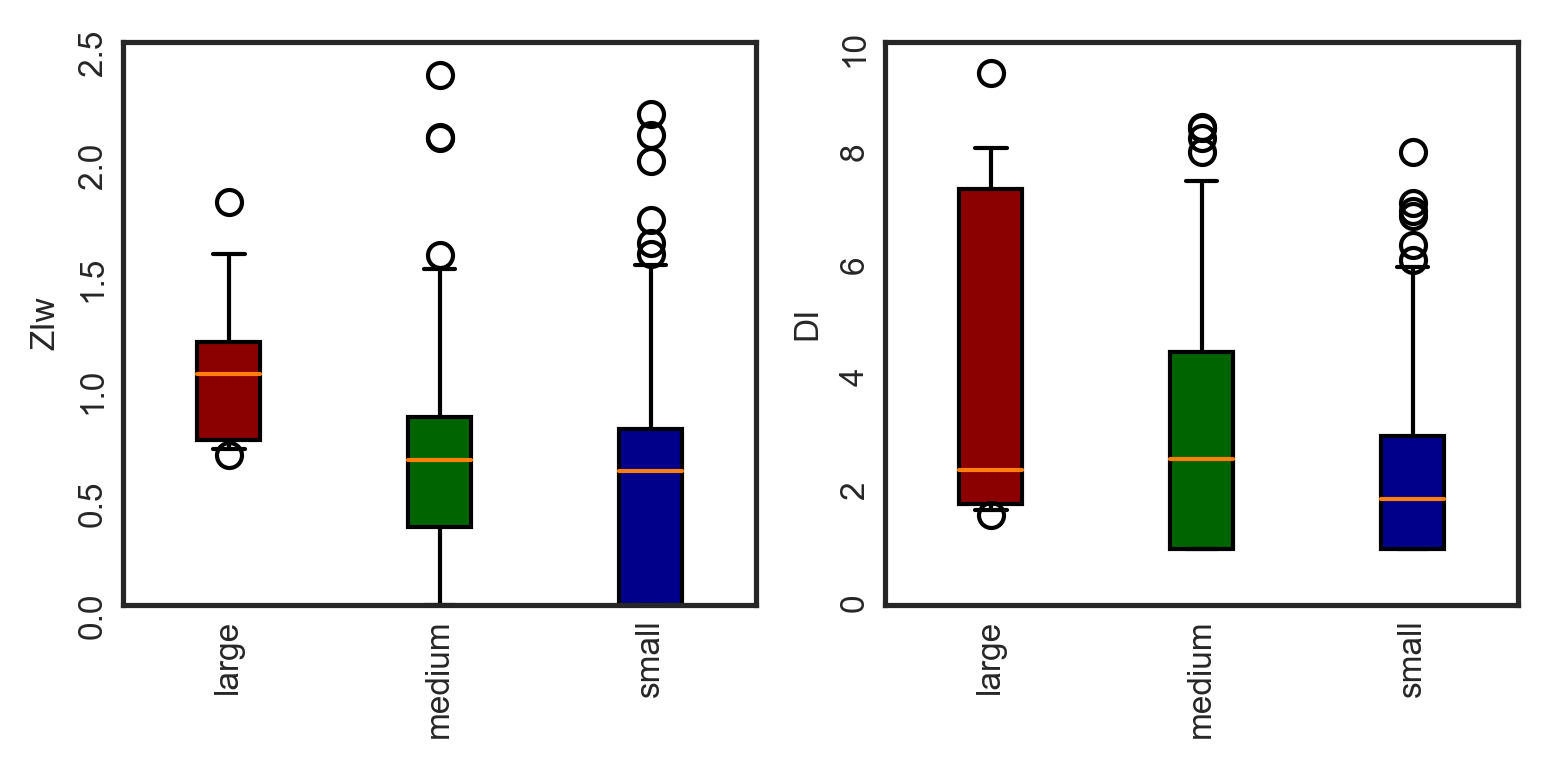

In [155]:
cities_large = roman_cities_wo[roman_cities_wo["pop_est"]>=30000]
cities_medium = roman_cities_wo[(roman_cities_wo["pop_est"] >= 5000) & (roman_cities_wo["pop_est"] < 30000)]
cities_small = roman_cities_wo[roman_cities_wo["pop_est"]<5000]

fig, [ax1, ax2] = plt.subplots(1,2, figsize=[5.2, 2.6], tight_layout=True)

bplot1 = ax1.boxplot([cities_large["ZIw"], cities_medium["ZIw"], cities_small["ZIw"]], whis=[2.5, 97.5], labels=["large", "medium", "small"],
                     patch_artist=True)
#ax1.set_title("A")
ax1.set_ylabel("ZIw")
ax1.tick_params(labelrotation=90)
ax1.set_ylim(0, 2.5)
#ax1.set_ylim(0, 5)

bplot2 = ax2.boxplot([cities_large["DI"], cities_medium["DI"], cities_small["DI"]], whis=[2.5, 97.5], labels=["large", "medium", "small"],
                     patch_artist=True)
#ax1.set_title("A")
ax2.set_ylabel("DI")
ax2.tick_params(labelrotation=90)
ax2.set_ylim(0, 10)

# fill with colors
colors = ["darkred", "darkgreen", "darkblue"]
#for bplot in bplot1:
for bplot in [bplot1, bplot2]:
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)

In [380]:
cities_large = roman_cities_wo[(roman_cities_wo["pop_est"]>=30000) & (roman_cities_wo["Ancient Toponym"]!="Roma")]
cities_large

,Primary Key,Ancient Toponym,Modern Toponym,Province,Country,Barrington Atlas Rank,Barrington Atlas Reference,Start Date,End Date,Select Bibliography,...,ZIw,shares_weighted_vec,RZI,RZI_cat,RZIw,DI,DIw,city_province,DZI,DI/ZIw
171,Hanson2016_172,Carthago,Tunis,Africa Proconsularis,Tunisia,1,32 F3,-49,NaN,Bomgardner 2000; Brunt 1971; Cornell and Mathe...,...,1.559581,"[1.3711439588688947, 0.0, 0.0, 0.0, 5.40582770...",5.405828,Miscellaneous Services,11.241103,1.684211,0.809934,Carthago (Africa Proconsularis),1.079912,1.079912
179,Hanson2016_180,Lepcis Magna,Lebda,Africa Proconsularis,Libya,1,35 G2,-30,NaN,Bomgardner 2000; Golvin 1988; Humphrey 1986; L...,...,1.083220,"[0.0, 0.0, 0.0, 0.0, 2.8831081081081082, 1.696...",3.092029,Building,8.373370,2.777778,1.025748,Lepcis Magna (Africa Proconsularis),2.564371,2.564371
398,Hanson2016_399,Londinium,London,Britannia,United Kingdom,2,8 G3,60,NaN,McEvedy 2011; Millett 1990: Table 4.4; Millett...,...,1.194506,"[7.312767780634105, 0.0, 0.0, 0.0, 0.0, 0.0, 0...",7.312768,Metal-Working,13.102721,2.000000,1.116221,Londinium (Britannia),1.674332,1.674332
601,Hanson2016_602,Augustodunum,Autun,Gallia Lugdunensis,France,4 or 5,18 B3,-27,NaN,Benario 1981; Golvin 1988; MacMullen 2000; McE...,...,0.732408,"[0.0, 0.0, 0.0, 0.0, 4.805180180180179, 0.0, 0...",5.153382,Building,5.661568,1.800000,1.638431,Augustodunum (Gallia Lugdunensis),2.457646,2.457646
619,Hanson2016_620,Lugdunum,Lyon,Gallia Lugdunensis,France,1,17 D2,-43,NaN,Benario 1981; Brunt 1971; Cornell and Mathews ...,...,0.693147,"[0.0, 0.0, 0.0, 4.13468992248062, 1.3514569256...",4.134690,Transport,11.463795,6.400000,2.308312,Lugdunum (Gallia Lugdunensis),9.233248,9.233248
650,Hanson2016_651,Narbo Martius,Narbonne,Gallia Narbonensis,France,2,25 H2,-45,NaN,Bedon 2001; Bedon et al 1988; Brunt 1971; Corn...,...,1.039721,"[0.0, 0.0, 0.0, 0.0, 5.405827702702703, 0.0, 0...",5.405828,Miscellaneous Services,7.494068,1.600000,1.154156,Narbo Martius (Gallia Narbonensis),1.538875,1.538875
651,Hanson2016_652,Nemausus,Nîmes,Gallia Narbonensis,France,3,15 C2,-52,NaN,Bedon 2001; Bedon et al 1988; Benario 1981; Bo...,...,0.732408,"[0.0, 0.0, 0.0, 22.051679586563306, 0.0, 0.0, ...",22.051680,Transport,24.226246,1.800000,1.638431,Nemausus (Gallia Narbonensis),2.457646,2.457646
757,Hanson2016_758,Capua,S. Maria di Capua Vetere,Italia (I Latium and Campania),Italy,2,44 F3,-550,NaN,Beloch 1880; Beloch 1886; Benario 1981; Bispha...,...,0.665851,"[1.9076785514697665, 2.108201581027668, 3.0413...",3.041340,Finance,11.644200,9.446429,2.467306,Capua (Italia (I Latium and Campania)),14.187008,14.187008
787,Hanson2016_788,Ostia,Ostia,Italia (I Latium and Campania),Italy,2,43 B2,-350,NaN,Beloch 1880; Boatwright 2000; Cornell and Math...,...,1.010435,"[1.2983893814595249, 1.9791280148423005, 0.571...",6.075463,Transport,33.422689,8.110390,1.474279,Ostia (Italia (I Latium and Campania)),8.026631,8.026631


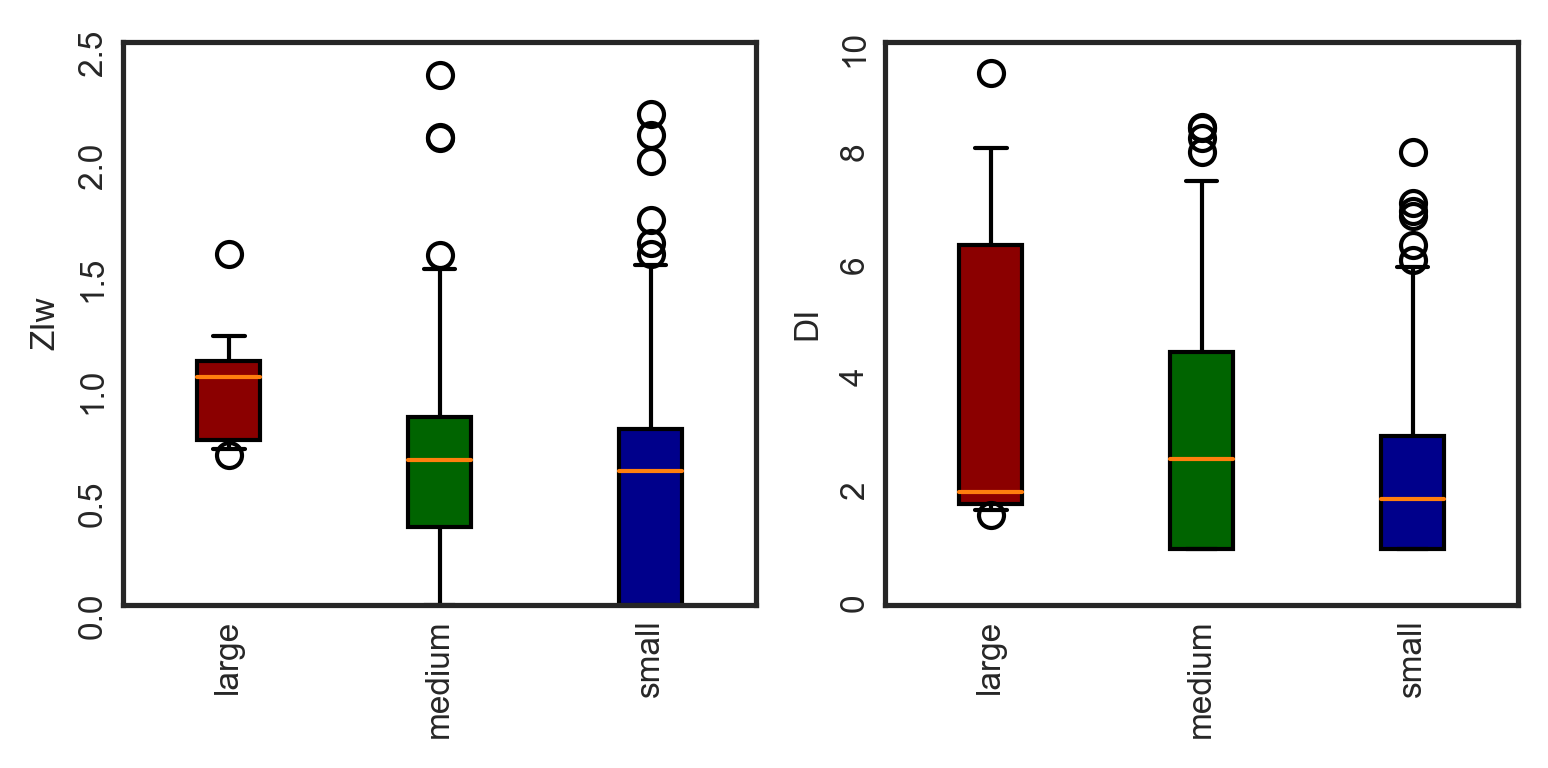

In [381]:
fig, [ax1, ax2] = plt.subplots(1,2, figsize=[5.2, 2.6], tight_layout=True)

bplot1 = ax1.boxplot([cities_large["ZIw"], cities_medium["ZIw"], cities_small["ZIw"]], whis=[2.5, 97.5], labels=["large", "medium", "small"],
                     patch_artist=True)
#ax1.set_title("A")
ax1.set_ylabel("ZIw")
ax1.tick_params(labelrotation=90)
ax1.set_ylim(0, 2.5)

bplot2 = ax2.boxplot([cities_large["DI"], cities_medium["DI"], cities_small["DI"]], whis=[2.5, 97.5], labels=["large", "medium", "small"],
                     patch_artist=True)
#ax1.set_title("A")
ax2.set_ylabel("DI")
ax2.tick_params(labelrotation=90)
ax2.set_ylim(0, 10)

# fill with colors
colors = ["darkred", "darkgreen", "darkblue"]
#for bplot in bplot1:
for bplot in [bplot1, bplot2]:
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)